# SOM Exploration with Provenance (Assignment 3)
New notebook for the ARFF dataset (China credit risk; target five_categories), keeping provenance logging.


In [11]:
# Imports
import os, json, datetime, uuid, typing
import numpy as np
import pandas as pd
from scipy.io import arff
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from PySOMVis.minisom import MiniSom
from starvers.starvers import TripleStoreEngine


In [12]:
executed_by = 'stud-id_12434740'
group_id = '02'
student_a = 'stud-id_12434740'
student_b = 'stud-id_12404765'
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

In [13]:
# Starvers endpoints and engine
get_endpoint = 'https://starvers.ec.tuwien.ac.at/BI2025'
post_endpoint = 'https://starvers.ec.tuwien.ac.at/BI2025/statements'
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)
base_iri_local = f'https://starvers.ec.tuwien.ac.at/SOS2025/{group_id}/'
prefixes = {
    'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    'iao': 'http://purl.obolibrary.org/obo/',
    'vivo': 'http://vivoweb.org/ontology/core#',
    '': base_iri_local,
}
def now():
    t = datetime.datetime.now(datetime.timezone.utc)
    return t.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'

In [14]:
# Register persons and roles (reuse from previous notebook if already inserted)
subj_a = f'<{base_iri_local}{student_a}>'
id_a   = f'<{base_iri_local}{student_a}_id>'
subj_b = f'<{base_iri_local}{student_b}>'
id_b   = f'<{base_iri_local}{student_b}_id>'
role_triples = [
    f'<{base_iri_local}{code_writer_role}> rdf:type prov:Role .',
    f'<{base_iri_local}{code_executor_role}> rdf:type prov:Role .',
]
reg_triples = [
    f'{subj_a} rdf:type foaf:Person .',
    f'{subj_a} rdf:type prov:Agent .',
    f'{subj_a} foaf:givenName "Jonas" .',
    f'{subj_a} foaf:familyName "Kruse" .',
    f'{id_a} rdf:type iao:IAO_0000578 .',
    f'{id_a} rdfs:label "Immatriculation number" .',
    f'{id_a} iao:IAO_0000219 "12434740"^^xsd:string .',
    f'{subj_a} vivo:identifier {id_a} .',
    f'{subj_b} rdf:type foaf:Person .',
    f'{subj_b} rdf:type prov:Agent .',
    f'{subj_b} foaf:givenName "Paul" .',
    f'{subj_b} foaf:familyName "Himstedt" .',
    f'{id_b} rdf:type iao:IAO_0000578 .',
    f'{id_b} rdfs:label "Immatriculation number" .',
    f'{id_b} iao:IAO_0000219 "12404765"^^xsd:string .',
    f'{subj_b} vivo:identifier {id_b} .',
]
engine.insert(role_triples, prefixes=prefixes)
engine.insert(reg_triples, prefixes=prefixes)

## Data Loading and Description

In [15]:
# Load ARFF dataset (China credit risk; target five_categories)
data_raw, meta = arff.loadarff('dataset_china.arff')
df = pd.DataFrame(data_raw)

# Decode byte strings and normalize missing markers in nominal columns
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].map(lambda v: v.decode('utf-8') if isinstance(v, (bytes, bytearray)) else v)
        df[c] = df[c].str.strip()
        df[c] = df[c].replace('?', np.nan)

target_col = 'five_categories'
id_cols = ['customer_id']
feature_cols = [c for c in df.columns if c not in ([target_col] + id_cols)]

X = df[feature_cols].copy()
y = df[target_col].astype('category')

display(df.head())
print('Shape:', df.shape)
print('Target counts:')
print(y.value_counts())


customer_id                              type_of_loan_business  \
0          1.0        Personal Housing Mortgage Loan (First hand)   
1          2.0        Personal Housing Mortgage Loan (First hand)   
2          3.0  Personal Commercial Housing Mortgage Loan (Fir...   
3          4.0                   Housing accumulation fund loan 3   
4          5.0  Personal Commercial Housing Mortgage Loan (Fir...   

   guarantee_the_balance  account_connection_amount  \
0              850000.00                  850000.00   
1             2143810.46                 2143810.46   
2              892500.00                  892500.00   
3                    NaN                        NaN   
4              606400.45                  606400.45   

   security_guarantee_amount five-level_classification  \
0                 85000000.0                        A1   
1                171504836.8                        A1   
2                 89250000.0                        A1   
3                        NaN                        A1   
4                 60640045.0                        A1   

  whether_interest_is_owed whether_self-service_loan  \
0                        N                         N   
1                        N                         N   
2                        N                         N   
3                        N                         N   
4                        N                         N   

              type_of_guarantee  safety_coefficient  ...  \
0  General Enterprise Guarantee               100.0  ...   
1                 Average house                80.0  ...   
2  General Enterprise Guarantee               100.0  ...   
3  General Enterprise Guarantee                 NaN  ...   
4                 Average house               100.0  ...   

   whether_interest_is_owed_(regulatory_standard)           repayment_type  \
0                                               N  Payment by installments   
1                                               N  Payment by installments   
2                                               N  Payment by installments   
3                                               N  Payment by installments   
4                                               N  Payment by installments   

  installment_repayment_method_(numerical_type)  \
0                                           2.0   
1                                           1.0   
2                                           2.0   
3                                           1.0   
4                                           1.0   

   installment_repayment_method_(discrete_type)  \
0                  Equal repayment of principal   
1           Matching the principal and interest   
2                  Equal repayment of principal   
3           Matching the principal and interest   
4           Matching the principal and interest   

  installment_repayment_cycle_(numerical_type)  \
0                                          M01   
1                                          M01   
2                                          M01   
3                                          M01   
4                                          M01   

  repayment_cycle_(discrete_type)  number_of_houses month_property_costs  \
0                           Month               1.0               343.84   
1                           Month               1.0               342.55   
2                           Month               NaN               282.00   
3                           Month               NaN                  NaN   
4                           Month               NaN                  NaN   

  family_monthly_income five_categories  
0              15000.00          Normal  
1              19700.00          Normal  
2              39678.00          Normal  
3               3490.00          Normal  
4              51502.56          Normal  

[5 rows x 28 columns]

Shape: (27522, 28)
Target counts:
five_categories
Normal        25516
Secondary      1445
Loss            349
Concern         109
Suspicious      103
Name: count, dtype: int64


In [16]:
# OpenML dataset metadata (snapshot)
openml_meta = {
    'id': '46444',
    'name': 'credit_risk_china',
    'version': '2',
    'description': 'Multi-classification assessment of bank (china) personal credit risk based on multi-source information fusion',
    'format': 'arff',
    'creator': 'AutoML Benchmark',
    'contributor': 'Sebastian Silva',
    'collection_date': '2024-11-25',
    'upload_date': '2024-11-25T15:44:20',
    'language': 'English',
    'licence': 'CC BY 4.0',
    'url': 'https://openml.org/data/v1/download/22121054/credit_risk_china.arff',
    'parquet_url': 'https://data.openml.org/datasets/0004/46444/dataset_46444.pq',
    'file_id': '22121054',
    'default_target_attribute': 'five_categories',
    'citation': 'Metaverse Financial Transactions Dataset',
    'md5_checksum': '7811dc62a74afaefce654ad54ded7b46',
    'openml_search_url': 'https://www.openml.org/search?type=data&status=active&id=46444&sort=runs',
}
dataset_entity = 'dataset_credit_risk_china'


Rows: 27522 Columns: 28
Numeric features: 11 Categorical features: 15
Overall missing: 36851 (4.78%)
Top missing features (count):


industry_category                                25444
number_of_houses                                  4571
month_property_costs                              1286
installment_repayment_method_(numerical_type)      757
installment_repayment_method_(discrete_type)       757
repayment_type                                     745
down_payment_amount                                620
collateral_value_(yuan)                            322
guarantee_method                                   304
safety_coefficient                                 304
dtype: int64

Top missing features (percent):


industry_category                                0.924497
number_of_houses                                 0.166085
month_property_costs                             0.046726
installment_repayment_method_(numerical_type)    0.027505
installment_repayment_method_(discrete_type)     0.027505
repayment_type                                   0.027069
down_payment_amount                              0.022527
collateral_value_(yuan)                          0.011700
guarantee_method                                 0.011046
safety_coefficient                               0.011046
dtype: float64

Top outlier features (count):


family_monthly_income                            3313
down_payment_amount                              2408
month_property_costs                             2258
collateral_value_(yuan)                          2105
account_connection_amount                        1710
guarantee_the_balance                            1490
security_guarantee_amount                        1406
approval_deadline                                  21
safety_coefficient                                  1
installment_repayment_method_(numerical_type)       0
dtype: int64

Class distribution:


five_categories
Normal        25516
Secondary      1445
Loss            349
Concern         109
Suspicious      103
Name: count, dtype: int64

min           max          mean           std
guarantee_the_balance         0.00  9.891190e+07  5.264648e+05  1.147352e+06
account_connection_amount   100.00  6.900000e+07  7.208506e+05  9.935134e+05
security_guarantee_amount     0.00  9.891190e+09  4.479974e+07  1.049060e+08
safety_coefficient           40.00  1.000000e+02  8.829003e+01  1.276365e+01
collateral_value_(yuan)    1738.32  2.800000e+09  6.713817e+07  1.896972e+08

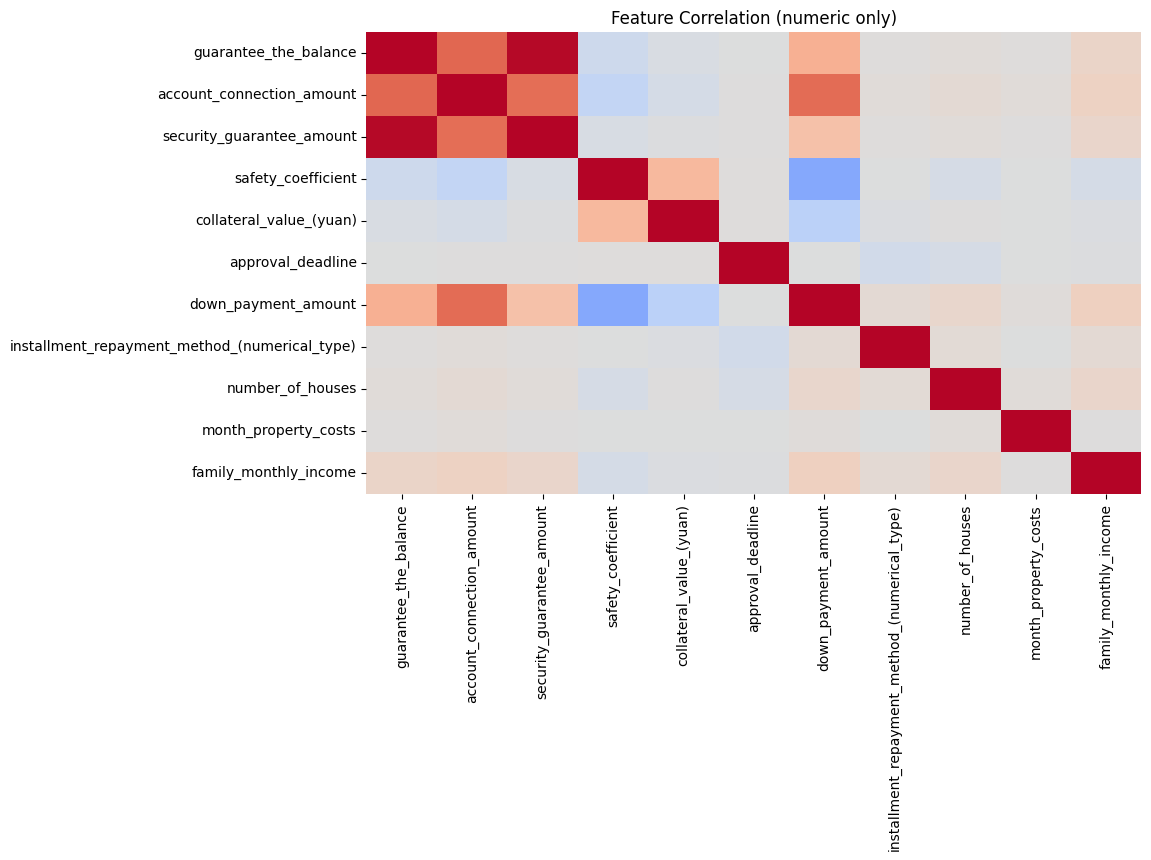

In [17]:
# Dataset characterization
X_num = X.select_dtypes(include=['number'])
X_cat = X.select_dtypes(include=['object'])

n_rows, n_cols = df.shape
num_cols = X_num.columns.tolist()
cat_cols = X_cat.columns.tolist()

missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / n_rows).sort_values(ascending=False)

overall_missing = int(missing_counts.sum())
overall_missing_pct = overall_missing / (n_rows * n_cols)

num_desc = X_num.describe().T if not X_num.empty else pd.DataFrame()

# Outliers (IQR rule) for numeric features
if not X_num.empty:
    def _outlier_count_iqr(s):
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        if iqr == 0 or pd.isna(iqr):
            return 0
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return int(((s < lower) | (s > upper)).sum())

    outlier_counts = X_num.apply(_outlier_count_iqr)
    outlier_pct = (outlier_counts / n_rows).sort_values(ascending=False)
else:
    outlier_counts = pd.Series(dtype=int)
    outlier_pct = pd.Series(dtype=float)

class_counts = y.value_counts()
class_pct = y.value_counts(normalize=True)

corr = X_num.corr(method='pearson') if not X_num.empty else None
if corr is not None:
    corr_pairs = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).stack()
    top_corr = corr_pairs.abs().sort_values(ascending=False).head(10)
    top_corr = {f"{a}__{b}": float(v) for (a, b), v in top_corr.items()}
else:
    top_corr = {}

hypotheses = [
    'Class imbalance with Normal as majority class.',
    'Missingness concentrated in guarantee/balance-related attributes.',
    'Loan type and guarantee method drive cluster structure.',
    'Some numeric attributes have heavy tails and outliers.',
]

# Display summaries
print('Rows:', n_rows, 'Columns:', n_cols)
print('Numeric features:', len(num_cols), 'Categorical features:', len(cat_cols))
print('Overall missing:', overall_missing, f"({overall_missing_pct:.2%})")
print('Top missing features (count):')
display(missing_counts.head(10))
print('Top missing features (percent):')
display(missing_pct.head(10))
print('Top outlier features (count):')
display(outlier_counts.sort_values(ascending=False).head(10))
print('Class distribution:')
display(class_counts)

if not num_desc.empty:
    display(num_desc[['min', 'max', 'mean', 'std']].head())

if corr is not None:
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, cmap='coolwarm', center=0, cbar=False)
    plt.title('Feature Correlation (numeric only)')
    plt.show()

# Log dataset metadata and characterization to PROV

def _json_literal(obj):
    return json.dumps(obj, ensure_ascii=True).replace('\\', '\\\\').replace('"', '\\"')

char_id = f'dataset_characterization_{uuid.uuid4().hex}'
assoc_id = f'assoc_{uuid.uuid4().hex}'

meta_literal = _json_literal(openml_meta)
char_payload = {
    'rows': n_rows,
    'columns': n_cols,
    'num_features': len(num_cols),
    'cat_features': len(cat_cols),
    'missing_total': overall_missing,
    'missing_pct': overall_missing_pct,
    'missing_by_feature': missing_counts.to_dict(),
    'missing_pct_by_feature': missing_pct.to_dict(),
    'outliers_by_feature': outlier_counts.to_dict(),
    'outlier_pct_by_feature': outlier_pct.to_dict(),
    'class_counts': class_counts.to_dict(),
    'class_pct': class_pct.to_dict(),
    'top_corr_abs': top_corr,
    'hypotheses': hypotheses,
}
char_literal = _json_literal(char_payload)

triples = [
    f':{dataset_entity} rdf:type sc:Dataset .',
    f':{dataset_entity} rdf:type cr:Dataset .',
    f':{dataset_entity} rdfs:label "{openml_meta["name"]}" .',
    f':{dataset_entity} sc:identifier "{openml_meta["id"]}"^^xsd:string .',
    f':{dataset_entity} sc:url "{openml_meta["openml_search_url"]}"^^xsd:anyURI .',
    f':{dataset_entity} sc:license "{openml_meta["licence"]}"^^xsd:string .',
    f':{dataset_entity} sc:version "{openml_meta["version"]}"^^xsd:string .',
    f':{dataset_entity} sc:description "{openml_meta["description"]}"^^xsd:string .',
    f':{dataset_entity} rdfs:comment "{meta_literal}" .',

    f':{char_id} rdf:type prov:Activity .',
    f':{char_id} rdfs:label "Dataset characterization" .',
    f':{char_id} prov:qualifiedAssociation :{assoc_id} .',
    f':{assoc_id} rdf:type prov:Association .',
    f':{assoc_id} prov:agent :{executed_by} .',
    f':{assoc_id} prov:hadRole :{code_executor_role} .',
    f':{char_id} prov:used :{dataset_entity} .',
    f':{char_id} prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':{char_id} prov:endedAtTime "{now()}"^^xsd:dateTime .',

    f':{char_id}_summary rdf:type prov:Entity .',
    f':{char_id}_summary rdfs:comment "{char_literal}" .',
    f':{char_id}_summary prov:wasGeneratedBy :{char_id} .',
]
engine.insert(triples, prefixes=prefixes)


## Preprocessing

In [18]:
# Preprocessing: impute + one-hot encode categorical features
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(include=['object']).columns

X[num_cols] = X[num_cols].apply(pd.to_numeric, errors='coerce')
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

X[cat_cols] = X[cat_cols].fillna('missing')

X_cat = pd.get_dummies(X[cat_cols], drop_first=False) if len(cat_cols) else pd.DataFrame(index=X.index)
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X[num_cols]) if len(num_cols) else np.empty((len(X), 0))

X_scaled = np.hstack([X_num_scaled, X_cat.to_numpy(dtype=float)]) if len(cat_cols) else X_num_scaled
feature_names = list(num_cols) + list(X_cat.columns)
feature_index = {name: idx for idx, name in enumerate(feature_names)}
print('Scaled shape:', X_scaled.shape)
print('Numeric features:', len(num_cols), 'Categorical (one-hot):', X_cat.shape[1])

# Log preprocessing to PROV

def _json_literal(obj):
    return json.dumps(obj, ensure_ascii=True).replace('\\', '\\\\').replace('"', '\\"')

prep_id = f'preprocessing_{uuid.uuid4().hex}'
assoc_id = f'assoc_{uuid.uuid4().hex}'
prep_entity = f'{dataset_entity}_preprocessed'

prep_payload = {
    'steps': [
        'decode bytes to strings',
        'normalize missing markers (?) to NaN',
        'median imputation for numeric features',
        'fill categorical missing with "missing"',
        'one-hot encode categoricals',
        'standardize numeric features (z-score)',
        'concatenate numeric + one-hot features',
    ],
    'numeric_features': list(num_cols),
    'categorical_features': list(cat_cols),
    'one_hot_dim': int(X_cat.shape[1]),
    'scaled_shape': list(X_scaled.shape),
}
prep_literal = _json_literal(prep_payload)

triples = [
    f':{prep_id} rdf:type prov:Activity .',
    f':{prep_id} rdfs:label "Preprocessing" .',
    f':{prep_id} prov:qualifiedAssociation :{assoc_id} .',
    f':{assoc_id} rdf:type prov:Association .',
    f':{assoc_id} prov:agent :{executed_by} .',
    f':{assoc_id} prov:hadRole :{code_executor_role} .',
    f':{prep_id} prov:used :{dataset_entity} .',
    f':{prep_id} prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':{prep_id} prov:endedAtTime "{now()}"^^xsd:dateTime .',

    f':{prep_entity} rdf:type prov:Entity .',
    f':{prep_entity} rdfs:label "Preprocessed feature matrix" .',
    f':{prep_entity} rdfs:comment "{prep_literal}" .',
    f':{prep_entity} prov:wasDerivedFrom :{dataset_entity} .',
    f':{prep_entity} prov:wasGeneratedBy :{prep_id} .',
]
engine.insert(triples, prefixes=prefixes)


Scaled shape: (27522, 112)
Numeric features: 11 Categorical (one-hot): 101


## SOM Utilities

In [19]:
def topographic_error(som: MiniSom, data: np.ndarray) -> float:
    # Use built-in method of MiniSom (compatible with bundled PySOMVis).
    return som.topographic_error(data)

def u_matrix(som: MiniSom, scaling='sum') -> np.ndarray:
    return som.distance_map(scaling=scaling)

def train_som(config: dict, data: np.ndarray):
    m, n = config['m'], config['n']
    sigma = config['sigma']
    lr = config['learning_rate']
    iters = config['iterations']
    seed = config.get('seed', 0)
    # MiniSom expects x,y instead of m,n
    som = MiniSom(x=m, y=n, input_len=data.shape[1], sigma=sigma, learning_rate=lr, random_seed=seed)
    som.random_weights_init(data)
    som.train_random(data, num_iteration=iters, verbose=False)
    q_error = som.quantization_error(data)
    t_error = topographic_error(som, data)
    return som, q_error, t_error

def log_run_prov(run_id: str, config: dict, q_error: float, t_error: float):
    assoc_id = f'assoc_{uuid.uuid4().hex}'
    # Escape backslashes and quotes so the JSON fits into a Turtle literal.
    cfg_literal = json.dumps(config).replace('\\', '\\\\').replace('"', '\\"')
    triples = [
        f':{run_id} rdf:type prov:Activity .',
        f':{run_id} rdfs:label "{config.get('desc','SOM run')}" .',
        f':{run_id} prov:qualifiedAssociation :{assoc_id} .',
        f':{assoc_id} rdf:type prov:Association .',
        f':{assoc_id} prov:agent :{executed_by} .',
        f':{assoc_id} prov:hadRole :{code_executor_role} .',
        f':{run_id} prov:startedAtTime "{now()}"^^xsd:dateTime .',
        f':{run_id} prov:endedAtTime "{now()}"^^xsd:dateTime .',
        f':{run_id}_config rdf:type prov:Entity .',
        f':{run_id}_config rdfs:comment "{cfg_literal}" .',
        f':{run_id}_config prov:wasGeneratedBy :{run_id} .',
        f':{run_id}_qe rdf:type prov:Entity .',
        f':{run_id}_qe rdfs:comment "quantization_error={q_error:.6f}" .',
        f':{run_id}_qe prov:wasGeneratedBy :{run_id} .',
        f':{run_id}_te rdf:type prov:Entity .',
        f':{run_id}_te rdfs:comment "topographic_error={t_error:.6f}" .',
        f':{run_id}_te prov:wasGeneratedBy :{run_id} .',
    ]
    engine.insert(triples, prefixes=prefixes)

## Experiment Grid (Tasks 1-7)

In [20]:
n = X_scaled.shape[0]
grid_reg = int(np.ceil(np.sqrt(n) / 2))
safe_sigma = grid_reg / 2
configs = [
    # Task 1: Regular SOM (Fixed Sigma and Iterations)
    # INCREASED ITERATIONS to ensure convergence (approx 5 epochs)
    {'run_id':'som_regular', 'desc':'Regular SOM', 'm':grid_reg, 'n':grid_reg, 
     'sigma':safe_sigma, 'learning_rate':0.5, 'iterations':10000, 'seed':1},

    # Task 2: Different Seed
    {'run_id':'som_seed_alt', 'desc':'Regular SOM different seed', 'm':grid_reg, 'n':grid_reg, 
     'sigma':safe_sigma, 'learning_rate':0.5, 'iterations':10000, 'seed':7},

    # Task 3: Map Sizes
    # Small map (sigma adjusted down slightly)
    {'run_id':'som_small', 'desc':'Small map', 'm':max(4, grid_reg//2), 'n':max(4, grid_reg//2), 
     'sigma':safe_sigma/2, 'learning_rate':0.5, 'iterations':10000, 'seed':1},
    # Large map (sigma adjusted up)
    {'run_id':'som_large', 'desc':'Large map', 'm':grid_reg*2, 'n':grid_reg*2, 
     'sigma':safe_sigma*2, 'learning_rate':0.5, 'iterations':10000, 'seed':1},

    # Task 4: Too Small Radius
    # Keep sigma tiny (0.5) to ensure it fails as requested
    {'run_id':'som_large_too_small_sigma', 'desc':'Large map too-small radius', 'm':grid_reg*2, 'n':grid_reg*2, 
     'sigma':0.5, 'learning_rate':0.5, 'iterations':10000, 'seed':1},

    # Task 5: Learning Rates
    {'run_id':'som_lr_too_high', 'desc':'Regular map high LR', 'm':grid_reg, 'n':grid_reg, 
     'sigma':safe_sigma, 'learning_rate':2.5, 'iterations':10000, 'seed':1}, # 2.5 ensures instability
    {'run_id':'som_lr_too_low', 'desc':'Regular map low LR', 'm':grid_reg, 'n':grid_reg, 
     'sigma':safe_sigma, 'learning_rate':0.01, 'iterations':10000, 'seed':1},
]
iters_sweep = [2,5,10,50,100,1000,5000,10000]
for k in iters_sweep:
    configs.append({'run_id':f'som_iter_{k}', 'desc':f'Iteration sweep {k}', 'm':grid_reg, 'n':grid_reg, 'sigma':safe_sigma, 'learning_rate':0.5, 'iterations':k, 'seed':1})
results = []
for cfg in configs:
    print('Training', cfg['run_id'])
    som, qe, te = train_som(cfg, X_scaled)
    results.append({'run_id':cfg['run_id'], 'desc':cfg['desc'], 'qe':qe, 'te':te, 'm':cfg['m'], 'n':cfg['n'], 'sigma':cfg['sigma'], 'lr':cfg['learning_rate'], 'iterations':cfg['iterations'], 'seed':cfg['seed']})
    log_run_prov(cfg['run_id'], cfg, qe, te)
results_df = pd.DataFrame(results)
display(results_df.sort_values('qe').head())

Training som_regular
Training som_seed_alt
Training som_small
Training som_large
Training som_large_too_small_sigma


/Users/paulhimstedt/Documents/TU_MASTER/self_organizing_systems/selforganisingsystems/PySOMVis-main/PySOMVis/minisom.py:535: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Training som_lr_too_high
Training som_lr_too_low
Training som_iter_2
Training som_iter_5
Training som_iter_10
Training som_iter_50
Training som_iter_100
Training som_iter_1000
Training som_iter_5000
Training som_iter_10000


run_id                        desc        qe        te  \
4  som_large_too_small_sigma  Large map too-small radius  0.056485  0.999746   
7                 som_iter_2           Iteration sweep 2  0.707833  0.981433   
8                 som_iter_5           Iteration sweep 5  1.019151  0.951166   
9                som_iter_10          Iteration sweep 10  1.332821  0.919882   
0                som_regular                 Regular SOM  1.367488  0.002580   

     m    n  sigma   lr  iterations  seed  
4  166  166    0.5  0.5       10000     1  
7   83   83   41.5  0.5           2     1  
8   83   83   41.5  0.5           5     1  
9   83   83   41.5  0.5          10     1  
0   83   83   41.5  0.5       10000     1

## Visualization Helpers

In [21]:
# Visualization helpers

def plot_heatmap(mat: np.ndarray, title: str, cmap: str = 'viridis'):
    plt.figure(figsize=(6,6))
    plt.title(title)
    plt.imshow(mat, cmap=cmap)
    plt.colorbar()
    plt.show()


def plot_umatrix(som: MiniSom, title='U-Matrix'):
    um = u_matrix(som)
    plot_heatmap(um, title, cmap='bone')


def compute_hits(som: MiniSom, data: np.ndarray) -> np.ndarray:
    hits = np.zeros((som._weights.shape[0], som._weights.shape[1]))
    for x in data:
        i, j = som.winner(x)
        hits[i, j] += 1
    return hits


def plot_hits(som: MiniSom, data: np.ndarray, title='Hit histogram'):
    hits = compute_hits(som, data)
    plot_heatmap(hits, title, cmap='viridis')


def class_hit_counts(som: MiniSom, data: np.ndarray, labels: pd.Series):
    classes = sorted(labels.unique())
    class_to_idx = {c: i for i, c in enumerate(classes)}
    counts = np.zeros((som._weights.shape[0], som._weights.shape[1], len(classes)), dtype=int)
    for x, label in zip(data, labels):
        i, j = som.winner(x)
        counts[i, j, class_to_idx[label]] += 1
    return counts, classes


def plot_class_map(som: MiniSom, data: np.ndarray, labels: pd.Series, title='Class map (dominant class)'):
    counts, classes = class_hit_counts(som, data, labels)
    totals = counts.sum(axis=2)
    dominant = counts.argmax(axis=2)
    dominant = np.where(totals > 0, dominant, np.nan)
    plt.figure(figsize=(6,6))
    cmap = plt.cm.get_cmap('tab10', len(classes))
    plt.title(title)
    plt.imshow(dominant, cmap=cmap, vmin=0, vmax=len(classes)-1)
    handles = [plt.matplotlib.patches.Patch(color=cmap(i), label=str(c)) for i, c in enumerate(classes)]
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


def plot_class_hits(som: MiniSom, data: np.ndarray, labels: pd.Series, max_classes: int = 6):
    counts, classes = class_hit_counts(som, data, labels)
    n = min(len(classes), max_classes)
    for i in range(n):
        plot_heatmap(counts[:, :, i], f'Class hits: {classes[i]}', cmap='viridis')


def plot_class_proportions(som: MiniSom, data: np.ndarray, labels: pd.Series, max_classes: int = 6):
    counts, classes = class_hit_counts(som, data, labels)
    totals = counts.sum(axis=2)
    n = min(len(classes), max_classes)
    for i in range(n):
        prop = np.where(totals > 0, counts[:, :, i] / totals, np.nan)
        plot_heatmap(prop, f'Class proportion: {classes[i]}', cmap='magma')


def compute_qe_map(som: MiniSom, data: np.ndarray) -> np.ndarray:
    weights = som._weights
    sums = np.zeros((weights.shape[0], weights.shape[1]))
    counts = np.zeros((weights.shape[0], weights.shape[1]))
    for x in data:
        i, j = som.winner(x)
        dist = np.linalg.norm(x - weights[i, j])
        sums[i, j] += dist
        counts[i, j] += 1
    return np.where(counts > 0, sums / counts, np.nan)


def compute_te_map(som: MiniSom, data: np.ndarray) -> np.ndarray:
    weights = som._weights
    violations = np.zeros((weights.shape[0], weights.shape[1]))
    counts = np.zeros((weights.shape[0], weights.shape[1]))
    for x in data:
        d = np.linalg.norm(weights - x, axis=2)
        bmu1 = np.unravel_index(np.argmin(d), d.shape)
        d[bmu1] = np.inf
        bmu2 = np.unravel_index(np.argmin(d), d.shape)
        i1, j1 = bmu1
        i2, j2 = bmu2
        counts[i1, j1] += 1
        if max(abs(i1 - i2), abs(j1 - j2)) > 1:
            violations[i1, j1] += 1
    return np.where(counts > 0, violations / counts, np.nan)


def plot_qe_map(som: MiniSom, data: np.ndarray, title='Quantization error map'):
    qe_map = compute_qe_map(som, data)
    plot_heatmap(qe_map, title, cmap='magma')


def plot_te_map(som: MiniSom, data: np.ndarray, title='Topology violation map'):
    te_map = compute_te_map(som, data)
    plot_heatmap(te_map, title, cmap='inferno')


def plot_component_planes(som: MiniSom, feature_names: list, features: list = None, max_features: int = 9):
    if features is None:
        features = feature_names[:max_features]
    indices = [feature_index[f] for f in features if f in feature_index]
    if not indices:
        print('No matching features for component planes.')
        return
    n = len(indices)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    weights = som._weights
    plt.figure(figsize=(4*ncols, 3*nrows))
    for k, idx in enumerate(indices):
        plt.subplot(nrows, ncols, k+1)
        plt.title(feature_names[idx])
        plt.imshow(weights[:, :, idx], cmap='coolwarm')
        plt.colorbar()
    plt.tight_layout()
    plt.show()


def plot_unit_dendrogram(som: MiniSom, method: str = 'ward', metric: str = 'euclidean', max_units: int = 400):
    weights = som._weights
    m, n, d = weights.shape
    flat = weights.reshape(m * n, d)
    if flat.shape[0] > max_units:
        print(f'Unit count {flat.shape[0]} > max_units {max_units}; reduce map or increase max_units.')
        return
    Z = linkage(flat, method=method, metric=metric)
    plt.figure(figsize=(10,4))
    plt.title('SOM unit dendrogram')
    dendrogram(Z, no_labels=True, color_threshold=None)
    plt.xlabel('Unit')
    plt.ylabel('Distance')
    plt.show()


def summarize_border_effects(som: MiniSom, data: np.ndarray):
    qe_map = compute_qe_map(som, data)
    te_map = compute_te_map(som, data)
    hits = compute_hits(som, data)

    m, n = qe_map.shape
    edge_mask = np.zeros((m, n), dtype=bool)
    edge_mask[0, :] = True
    edge_mask[-1, :] = True
    edge_mask[:, 0] = True
    edge_mask[:, -1] = True
    inner_mask = ~edge_mask

    def _mean(mask, arr):
        vals = arr[mask]
        vals = vals[~np.isnan(vals)]
        return float(np.nanmean(vals)) if vals.size else float('nan')

    qe_edge = _mean(edge_mask, qe_map)
    qe_inner = _mean(inner_mask, qe_map)
    te_edge = _mean(edge_mask, te_map)
    te_inner = _mean(inner_mask, te_map)

    hits_edge = float(hits[edge_mask].sum())
    hits_inner = float(hits[inner_mask].sum())
    hit_ratio = hits_edge / hits_inner if hits_inner > 0 else float('inf')

    summary = {
        'qe_edge_mean': qe_edge,
        'qe_inner_mean': qe_inner,
        'te_edge_mean': te_edge,
        'te_inner_mean': te_inner,
        'hit_ratio_edge_to_inner': hit_ratio,
    }

    print('Border effect summary:')
    for k, v in summary.items():
        print(f"  {k}: {v:.4f}" if isinstance(v, float) and v == v else f"  {k}: {v}")
    return summary
def analyze_configs(cfg_list, title: str):
    print(title)
    for cfg in cfg_list:
        som, qe, te = train_som(cfg, X_scaled)
        print(f"{cfg['run_id']}: QE={qe:.4f}, TE={te:.4f}")
        plot_umatrix(som, title=f"U-Matrix: {cfg['run_id']}")
        plot_qe_map(som, X_scaled, title=f"QE map: {cfg['run_id']}")
        plot_te_map(som, X_scaled, title=f"TE map: {cfg['run_id']}")


som_regular: QE=1.3675, TE=0.0026


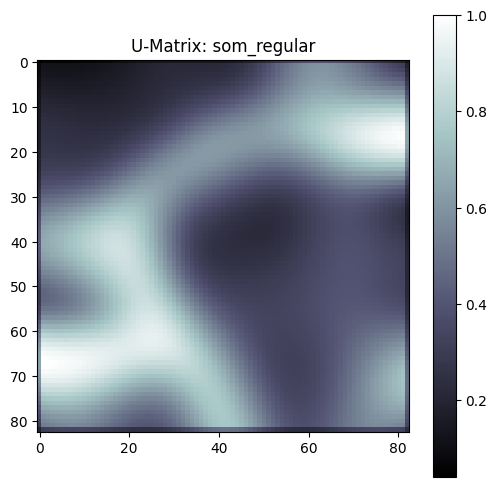

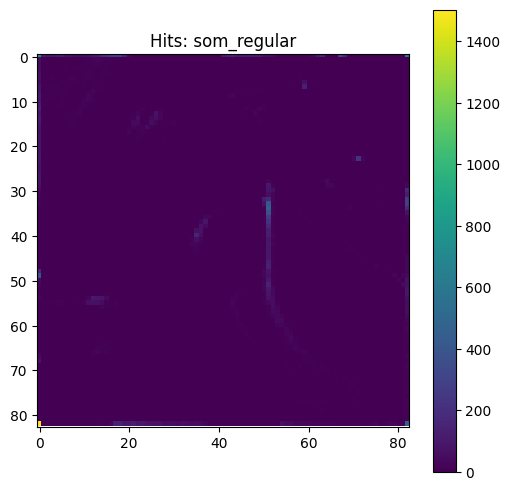

/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(classes))


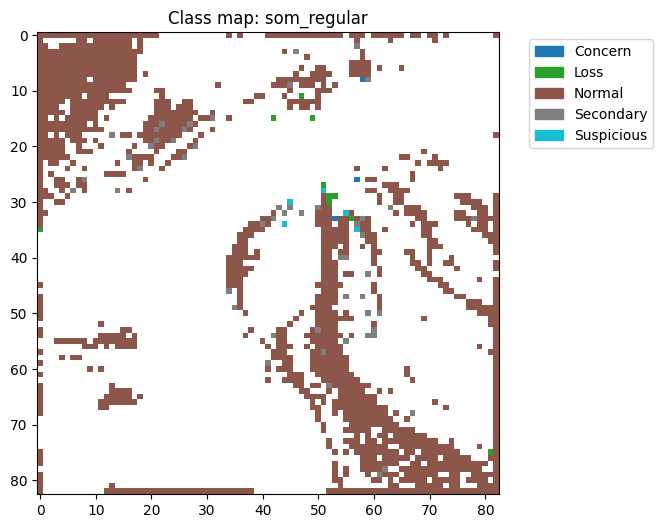

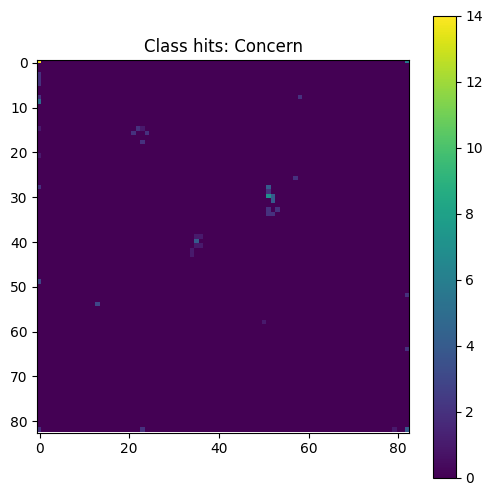

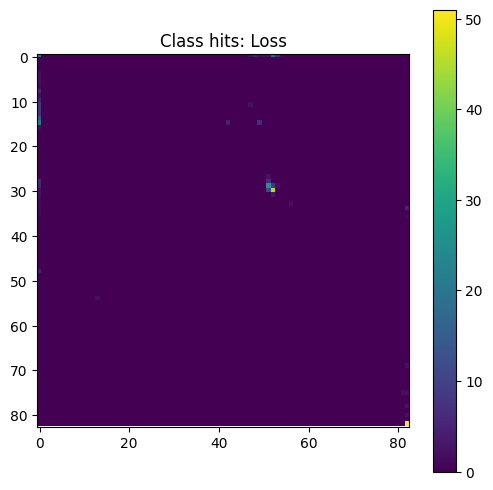

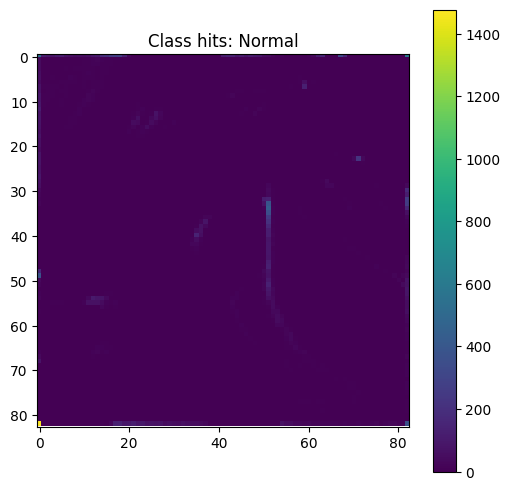

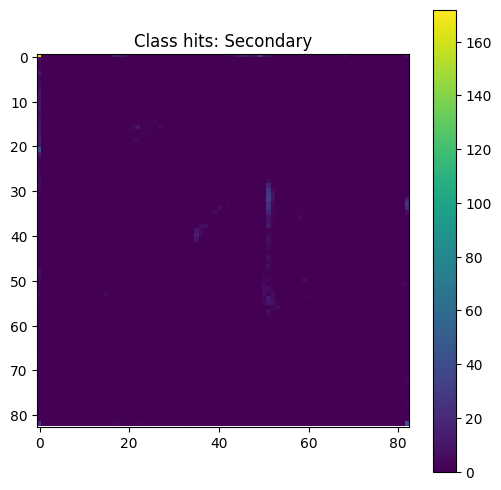

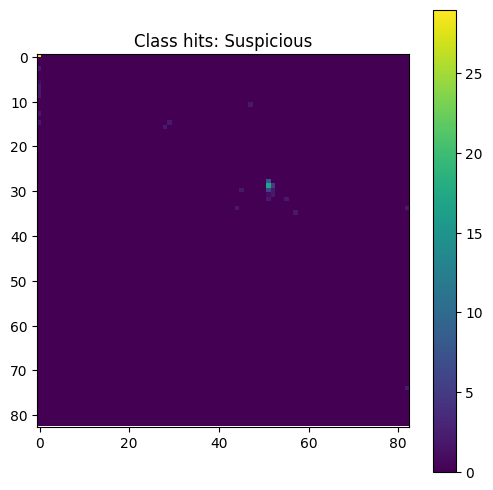

/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:78: RuntimeWarning: invalid value encountered in divide
  return np.where(counts > 0, sums / counts, np.nan)


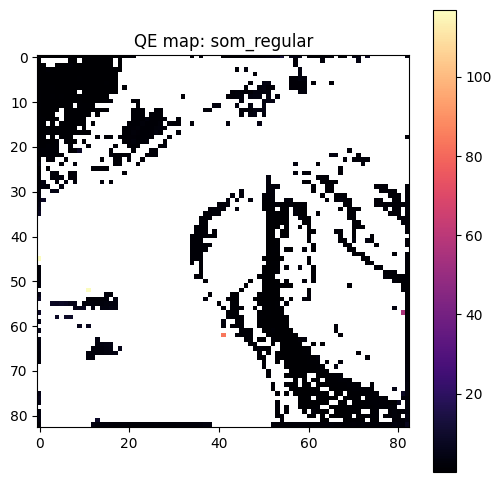

/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:95: RuntimeWarning: invalid value encountered in divide
  return np.where(counts > 0, violations / counts, np.nan)


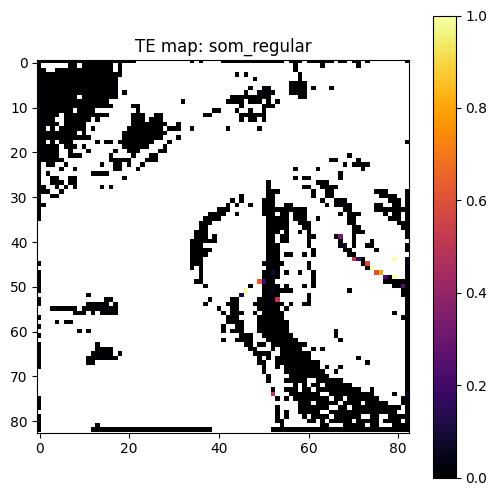

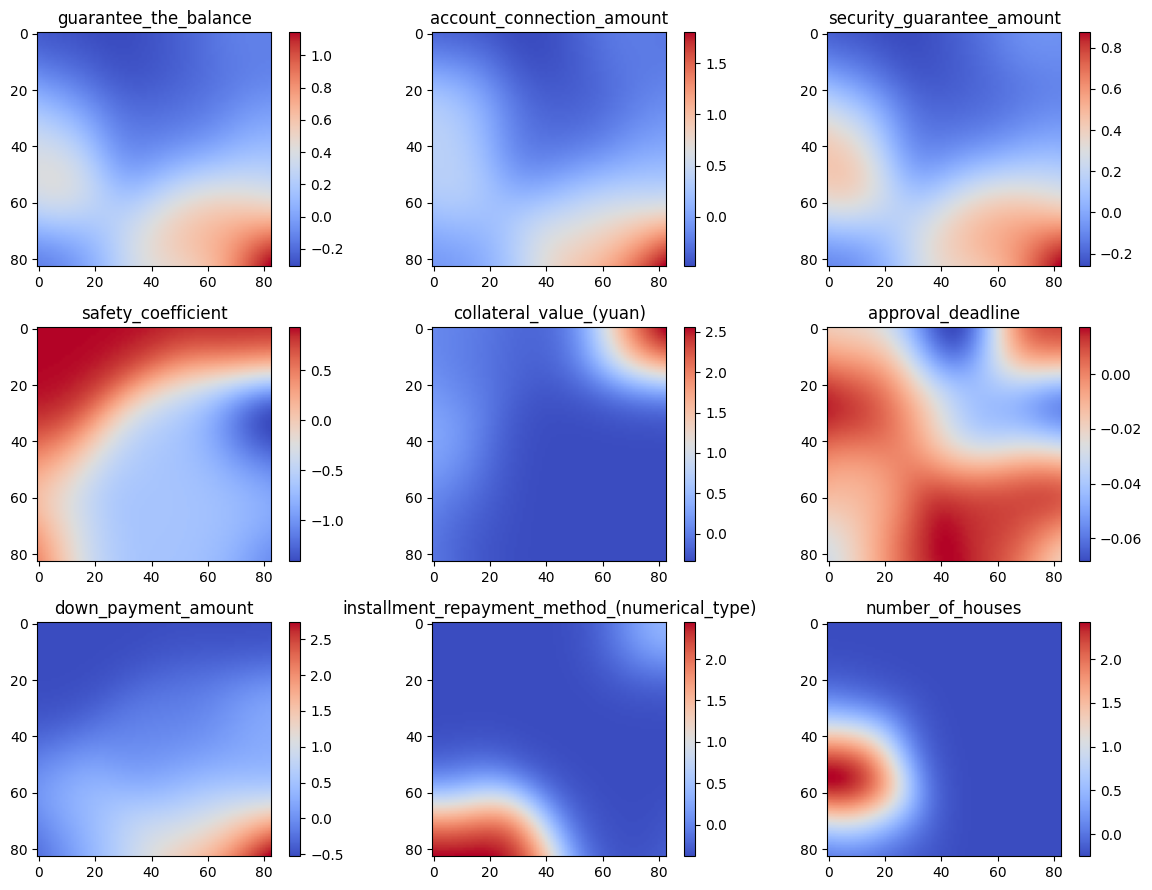

In [22]:
# Analysis: Regular SOM (Task C1)
reg_cfg = next(c for c in configs if c['run_id'] == 'som_regular')
som_reg, qe_reg, te_reg = train_som(reg_cfg, X_scaled)
print(f"som_regular: QE={qe_reg:.4f}, TE={te_reg:.4f}")

plot_umatrix(som_reg, title='U-Matrix: som_regular')
plot_hits(som_reg, X_scaled, title='Hits: som_regular')
plot_class_map(som_reg, X_scaled, y, title='Class map: som_regular')
plot_class_hits(som_reg, X_scaled, y, max_classes=5)
plot_qe_map(som_reg, X_scaled, title='QE map: som_regular')
plot_te_map(som_reg, X_scaled, title='TE map: som_regular')

if len(num_cols):
    plot_component_planes(som_reg, feature_names, features=num_cols[:9])


In [23]:
# Analysis: Border/magnification summary (Task C1)
border_summary = summarize_border_effects(som_reg, X_scaled)


/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:78: RuntimeWarning: invalid value encountered in divide
  return np.where(counts > 0, sums / counts, np.nan)
/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:95: RuntimeWarning: invalid value encountered in divide
  return np.where(counts > 0, violations / counts, np.nan)


Border effect summary:
  qe_edge_mean: 2.5477
  qe_inner_mean: 1.5825
  te_edge_mean: 0.0006
  te_inner_mean: 0.0078
  hit_ratio_edge_to_inner: 1.2931


/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:65: RuntimeWarning: invalid value encountered in divide
  prop = np.where(totals > 0, counts[:, :, i] / totals, np.nan)


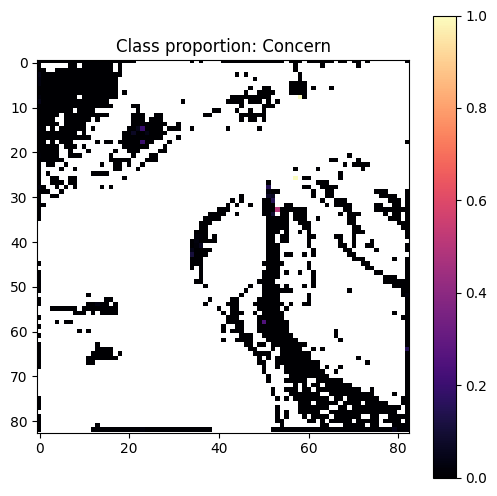

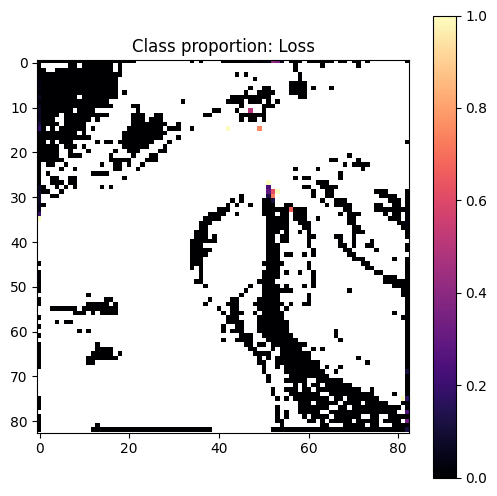

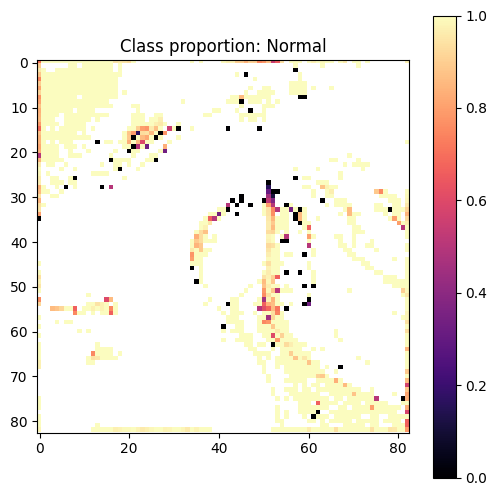

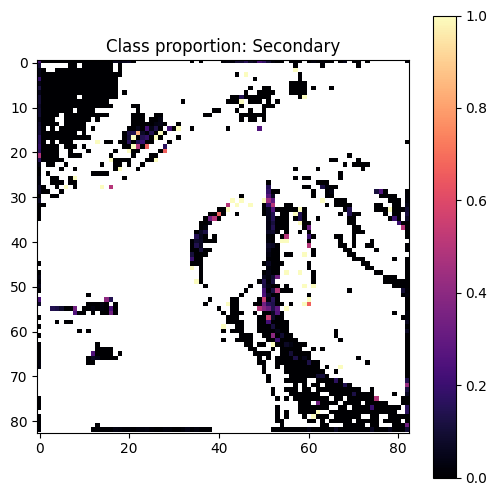

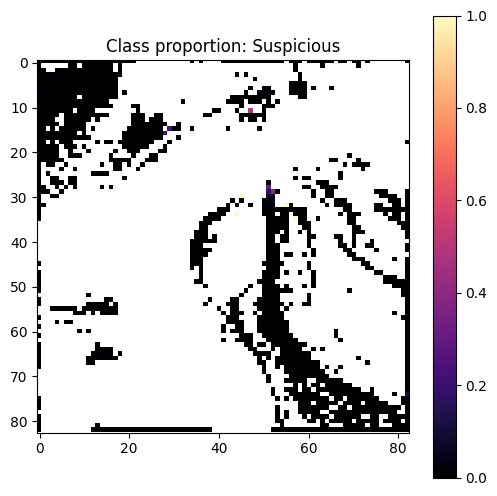

In [24]:
# Analysis: Class proportions (Task C1)
plot_class_proportions(som_reg, X_scaled, y, max_classes=5)


In [25]:
# Analysis: Unit hierarchy (Task C1/7)
plot_unit_dendrogram(som_reg, method='ward', metric='euclidean', max_units=400)


Unit count 6889 > max_units 400; reduce map or increase max_units.


In [26]:
# Observations: Regular SOM (Task C1)
# Fill in after running the visualizations above.
# - Border effect: note any higher QE/TE or dense hits at map edges.
# - Magnification: relate hit density to U-matrix distances.
# - Class structure: which classes form compact areas vs overlap.
# - QE/TE: where error concentrates and how that aligns with clusters.


In [27]:
# Observations: Seed comparison (Task C2)
# Fill in after running the seed comparison.
# - Stability of cluster layout and class regions.
# - Differences in QE/TE and boundary sharpness.


In [28]:
# Observations: Map size (Task C3)
# Fill in after running size comparison.
# - Small map: underfitting signs (merged clusters).
# - Large map: fragmentation or better separation.


In [29]:
# Observations: Sigma/LR (Tasks C4 & C5)
# Fill in after running sigma/LR comparison.
# - Too small sigma: topology violations or noisy maps.
# - LR too high/low: instability vs slow convergence.


In [30]:
# Observations: Iterations (Task C6)
# Fill in after running iteration sweep.
# - When structure emerges and stabilizes.
# - QE/TE trends indicating convergence.


Seed comparison
som_regular: QE=1.3675, TE=0.0026


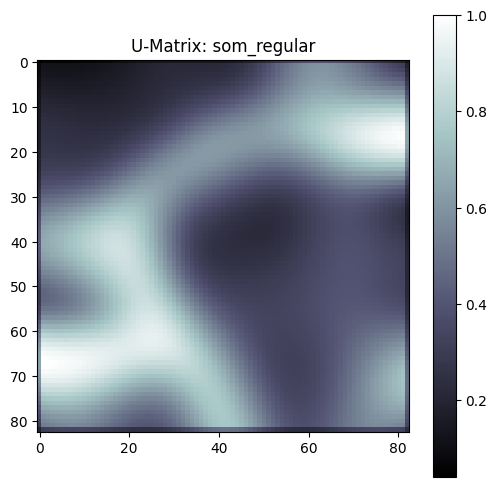

/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:78: RuntimeWarning: invalid value encountered in divide
  return np.where(counts > 0, sums / counts, np.nan)


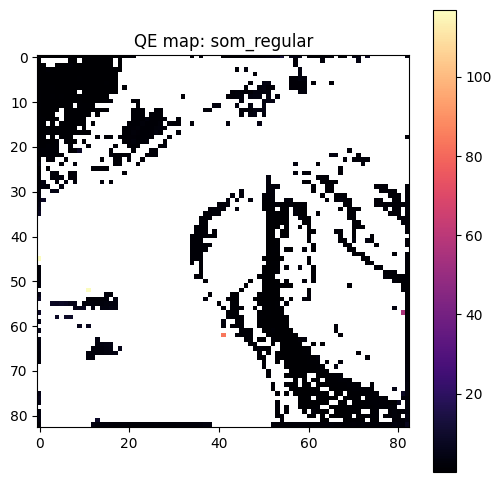

/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:95: RuntimeWarning: invalid value encountered in divide
  return np.where(counts > 0, violations / counts, np.nan)


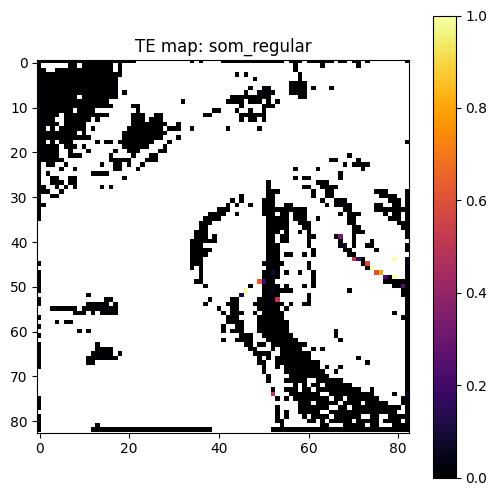

som_seed_alt: QE=1.4058, TE=0.0025


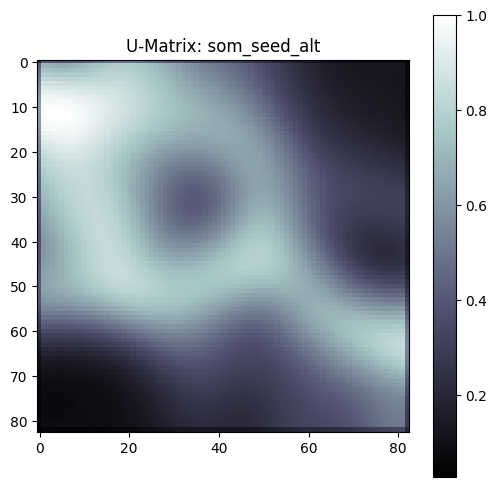

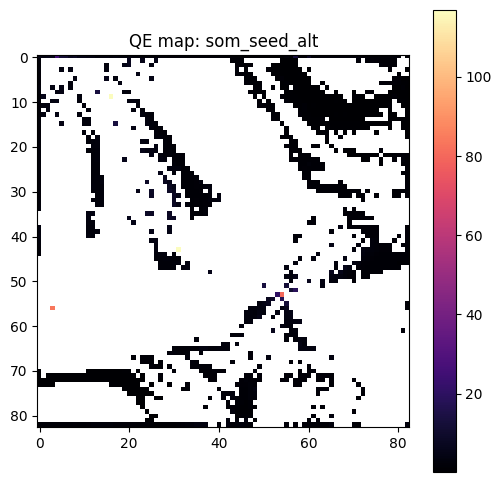

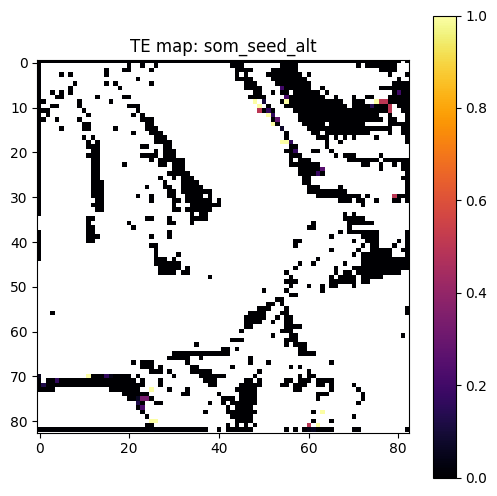

In [31]:
# Analysis: Seed comparison (Task C2)
seed_cfgs = [c for c in configs if c['run_id'] in ['som_regular', 'som_seed_alt']]
analyze_configs(seed_cfgs, title='Seed comparison')


Map size comparison
som_regular: QE=1.3675, TE=0.0026


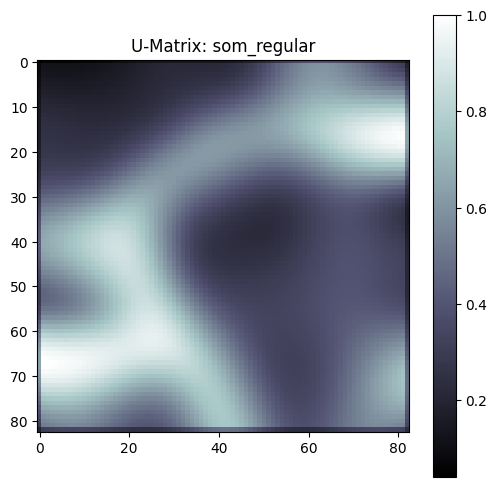

/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:78: RuntimeWarning: invalid value encountered in divide
  return np.where(counts > 0, sums / counts, np.nan)


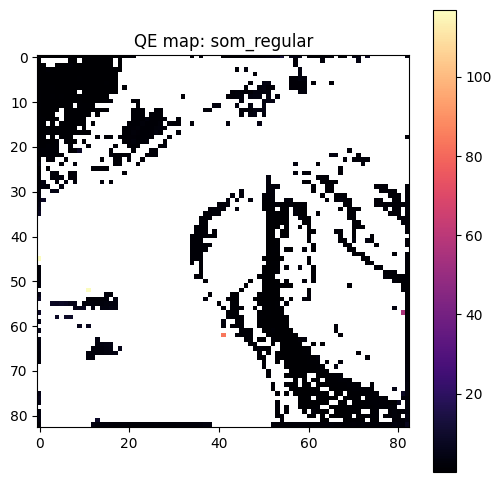

/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:95: RuntimeWarning: invalid value encountered in divide
  return np.where(counts > 0, violations / counts, np.nan)


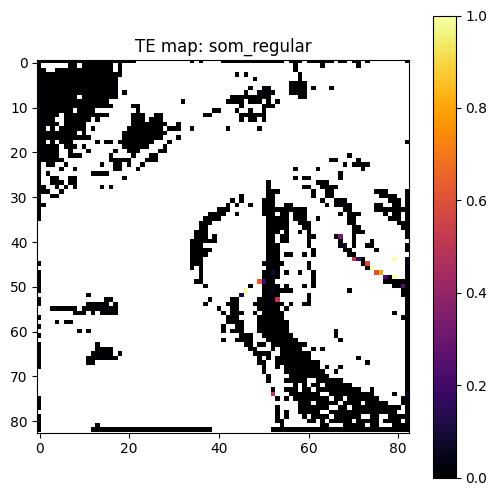

som_small: QE=1.4061, TE=0.0035


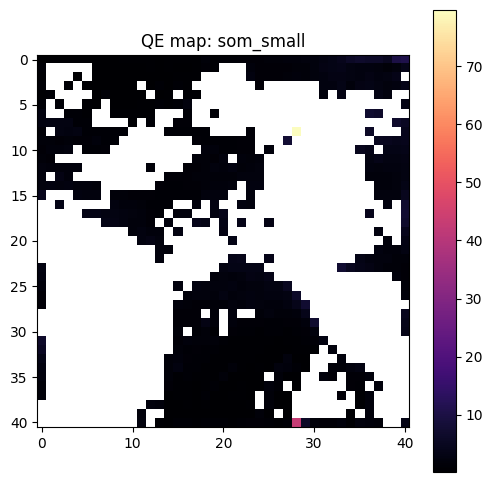

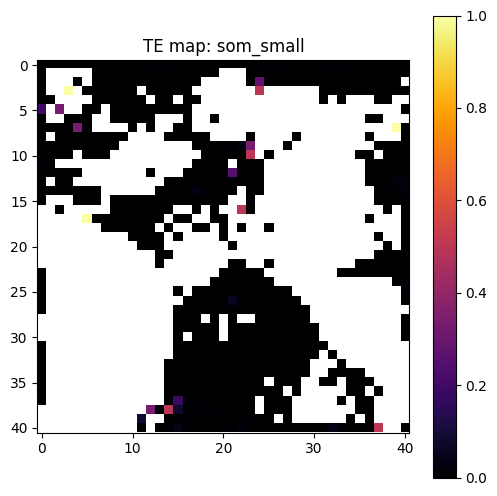

som_large: QE=1.4165, TE=0.0011


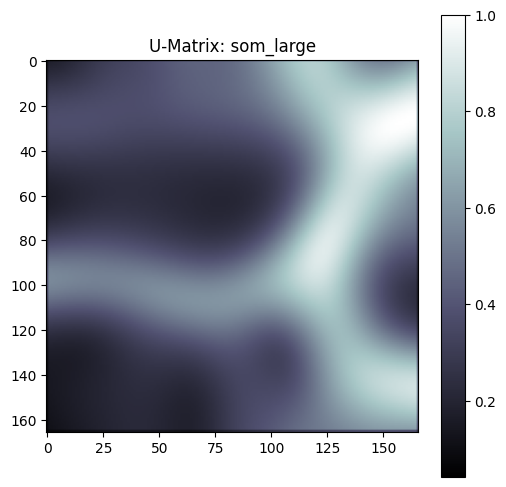

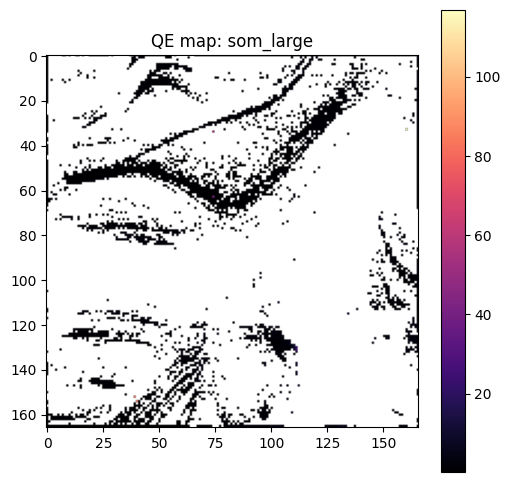

In [32]:
# Analysis: Map size comparison (Task C3)
size_cfgs = [c for c in configs if c['run_id'] in ['som_small', 'som_regular', 'som_large']]
analyze_configs(size_cfgs, title='Map size comparison')


Sigma / Learning rate comparison
som_regular: QE=1.3675, TE=0.0026


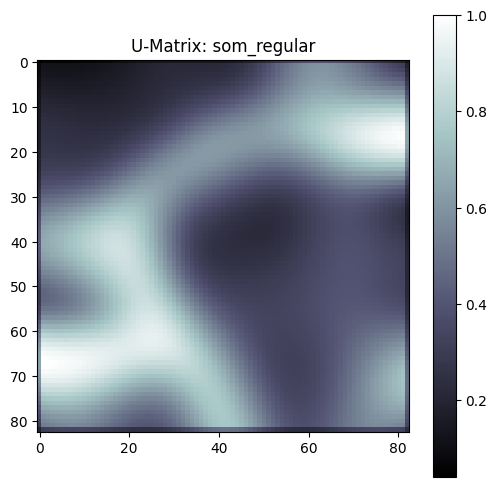

/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:78: RuntimeWarning: invalid value encountered in divide
  return np.where(counts > 0, sums / counts, np.nan)


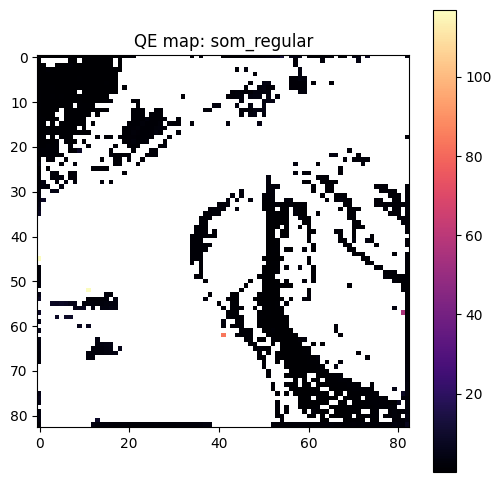

/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:95: RuntimeWarning: invalid value encountered in divide
  return np.where(counts > 0, violations / counts, np.nan)


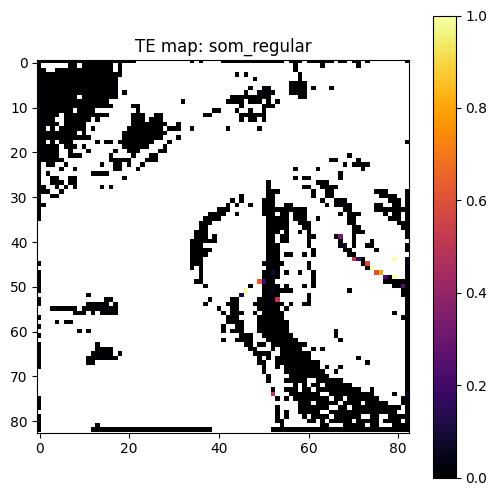

/Users/paulhimstedt/Documents/TU_MASTER/self_organizing_systems/selforganisingsystems/PySOMVis-main/PySOMVis/minisom.py:535: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


som_large_too_small_sigma: QE=0.0565, TE=0.9997


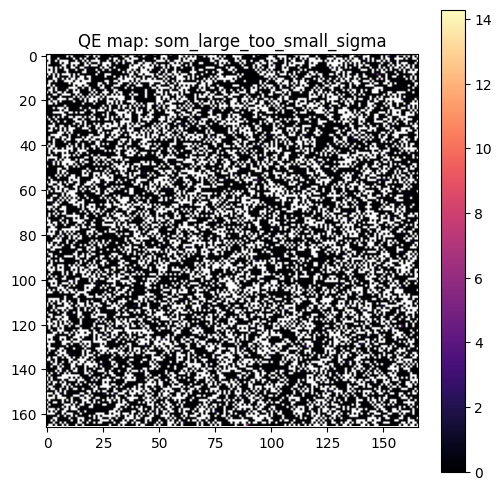

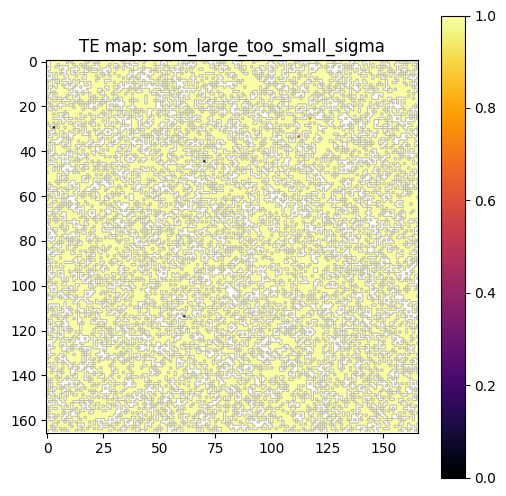

som_lr_too_high: QE=1.5527, TE=0.0185


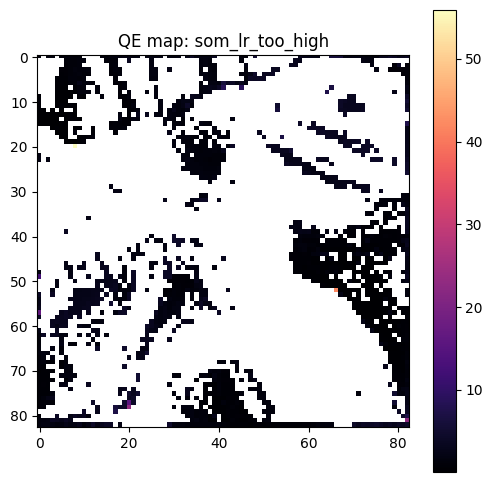

som_lr_too_low: QE=1.4788, TE=0.0028


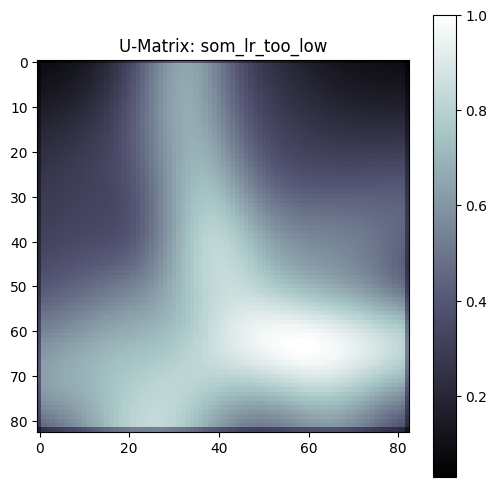

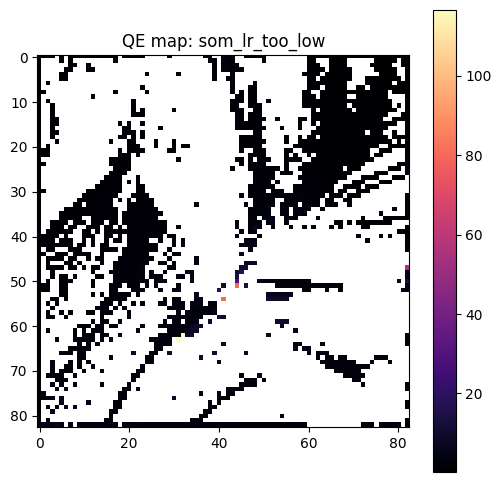

In [33]:
# Analysis: Sigma and learning rate (Tasks C4 & C5)
sigma_lr_cfgs = [c for c in configs if c['run_id'] in ['som_regular', 'som_large_too_small_sigma', 'som_lr_too_high', 'som_lr_too_low']]
analyze_configs(sigma_lr_cfgs, title='Sigma / Learning rate comparison')


Iteration sweep
som_iter_2: QE=0.7078, TE=0.9814


/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:78: RuntimeWarning: invalid value encountered in divide
  return np.where(counts > 0, sums / counts, np.nan)


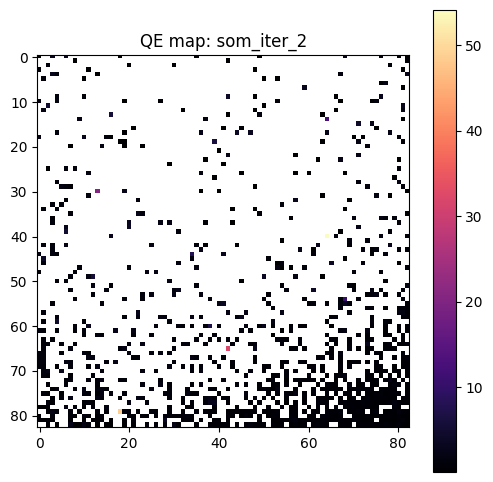

/var/folders/_z/x15hkr_n2d75mrp88gkcwgjw0000gn/T/ipykernel_33432/687652789.py:95: RuntimeWarning: invalid value encountered in divide
  return np.where(counts > 0, violations / counts, np.nan)


som_iter_5: QE=1.0192, TE=0.9512


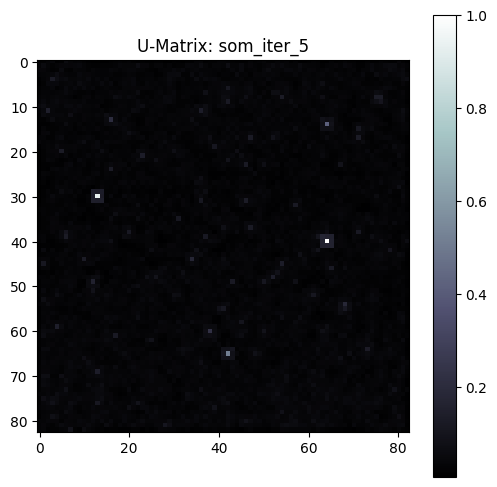

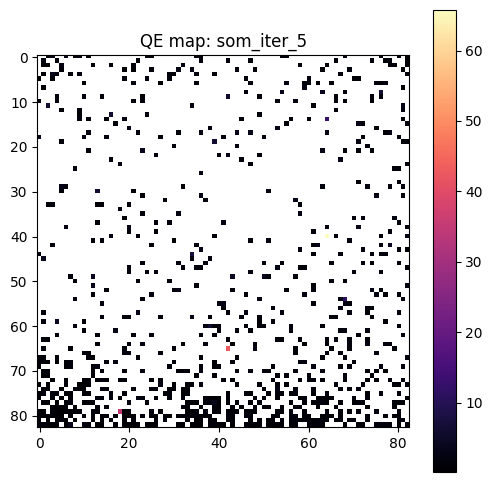

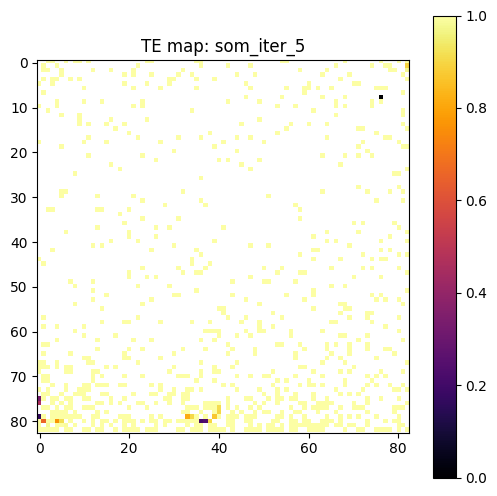

som_iter_10: QE=1.3328, TE=0.9199


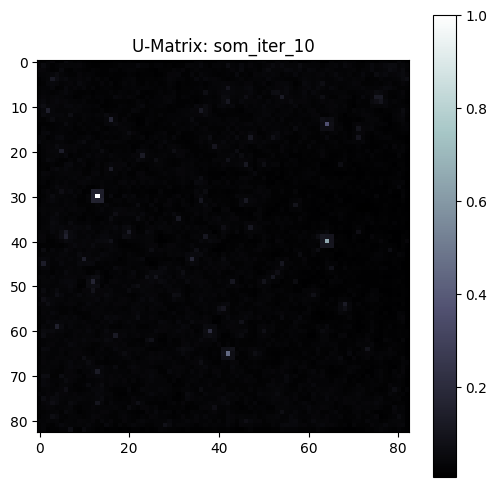

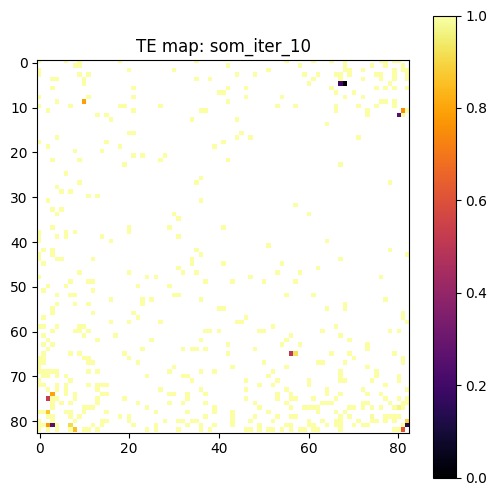

som_iter_50: QE=2.0714, TE=0.6452


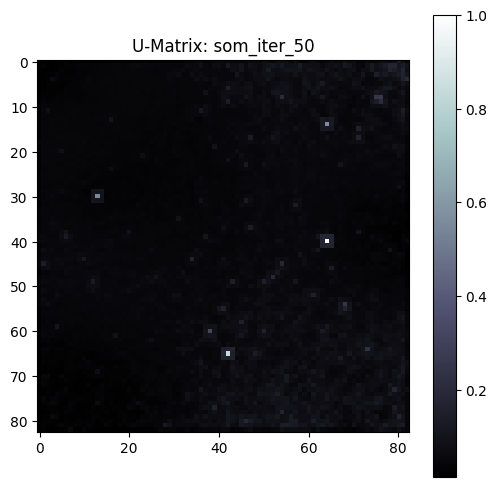

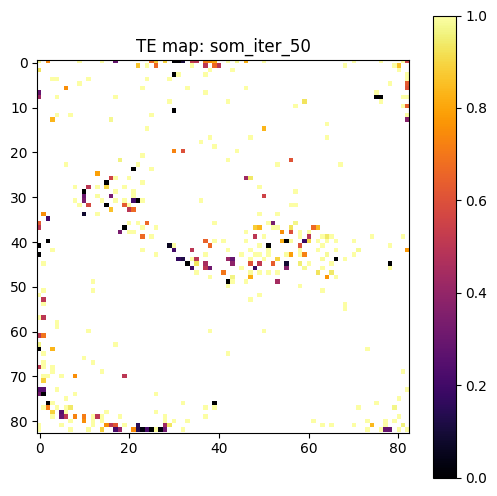

som_iter_100: QE=1.8203, TE=0.0535


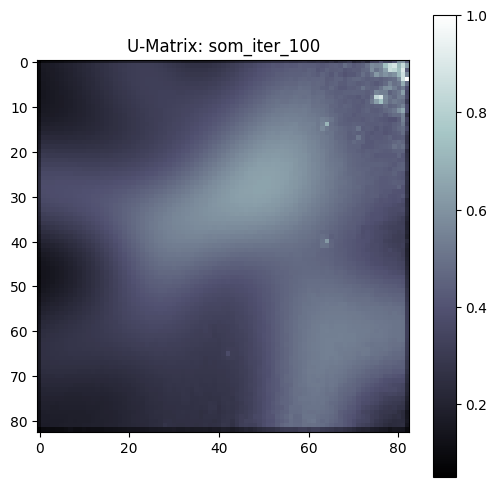

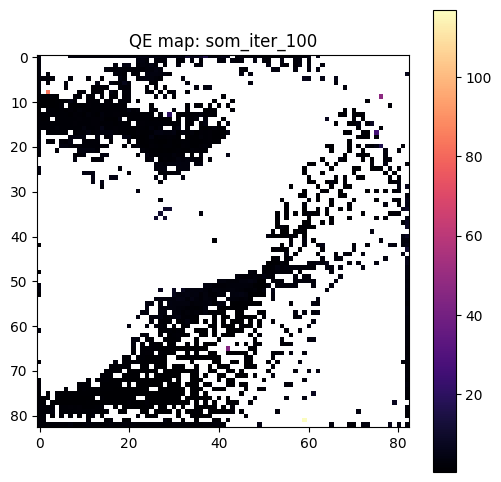

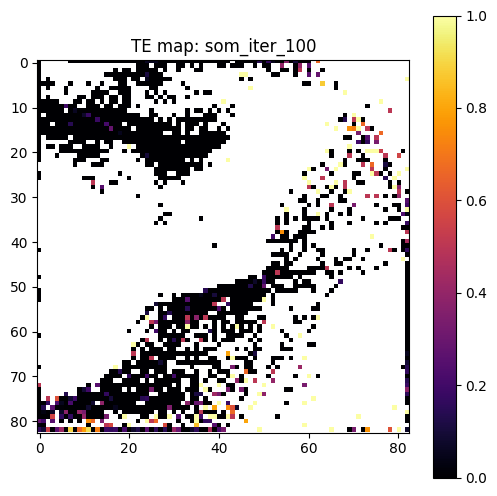

som_iter_1000: QE=1.4173, TE=0.0047


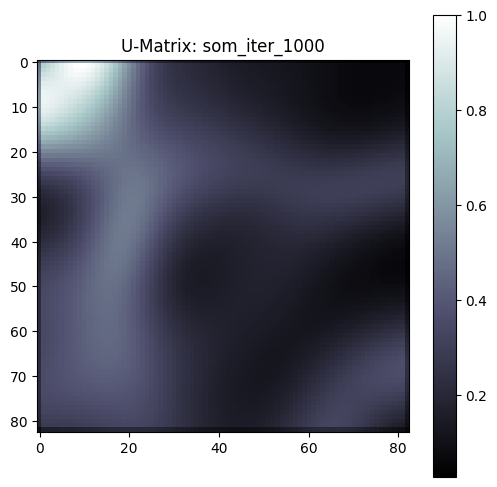

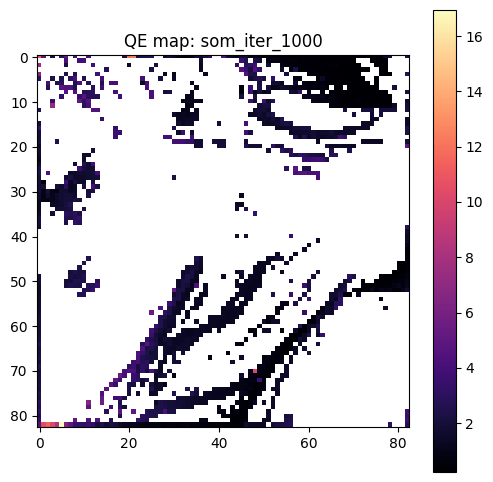

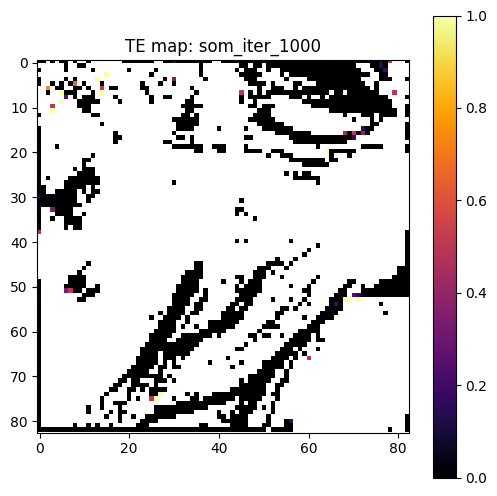

som_iter_5000: QE=1.3888, TE=0.0017


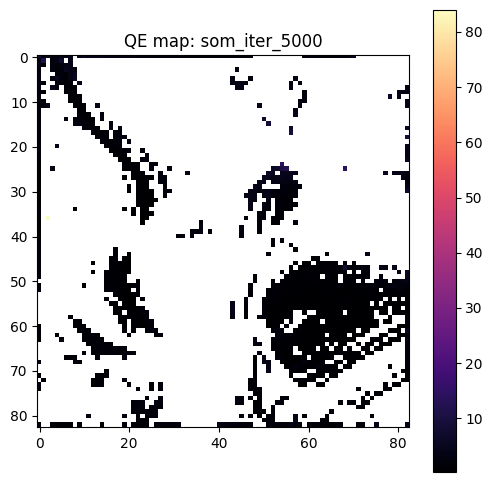

som_iter_10000: QE=1.3675, TE=0.0026


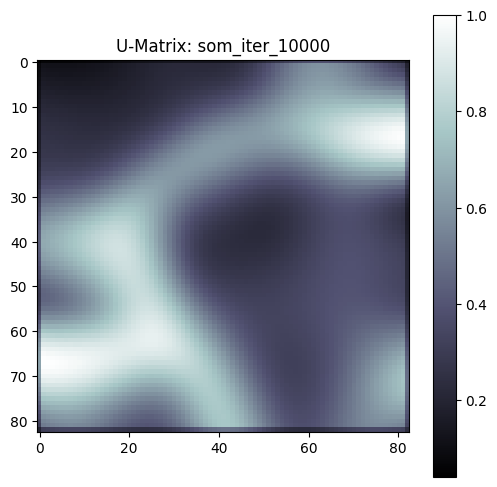

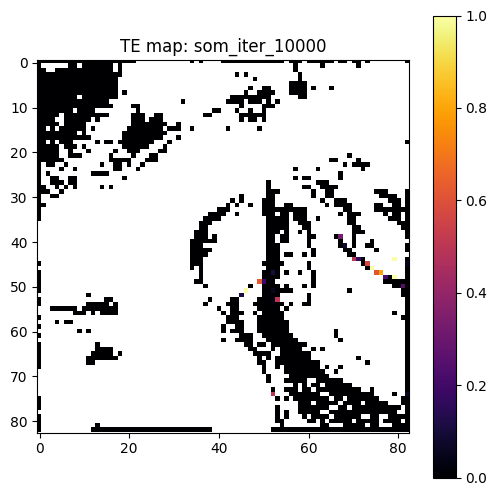

In [34]:
# Analysis: Iteration sweep (Task C6)
iter_cfgs = [c for c in configs if c['run_id'].startswith('som_iter_')]
# Keep this small if runtime is high; subset by editing iter_cfgs
analyze_configs(iter_cfgs, title='Iteration sweep')


## Example: Visualize the regular SOM

som_regular: QE=1.3675, TE=0.0026


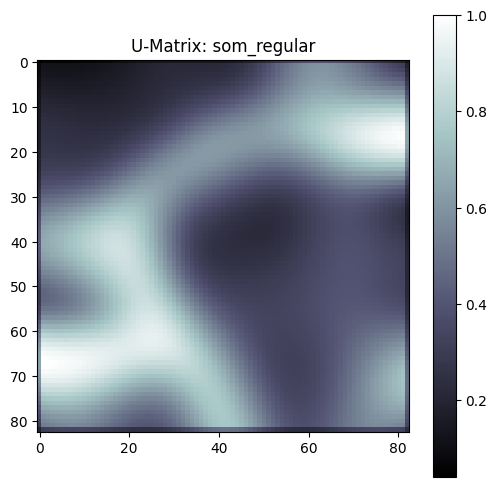

som_seed_alt: QE=1.4058, TE=0.0025


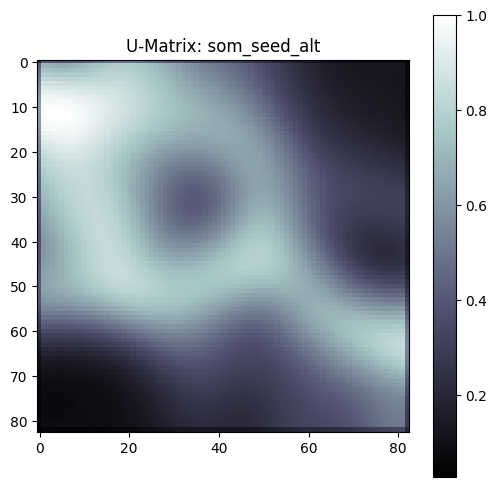

som_small: QE=1.4061, TE=0.0035


som_large: QE=1.4165, TE=0.0011


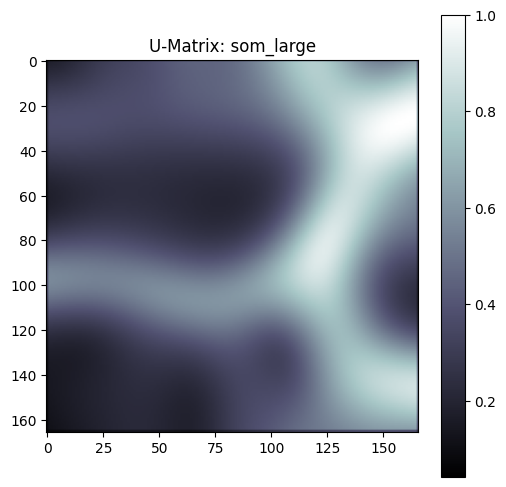

som_large_too_small_sigma: QE=0.0565, TE=0.9997


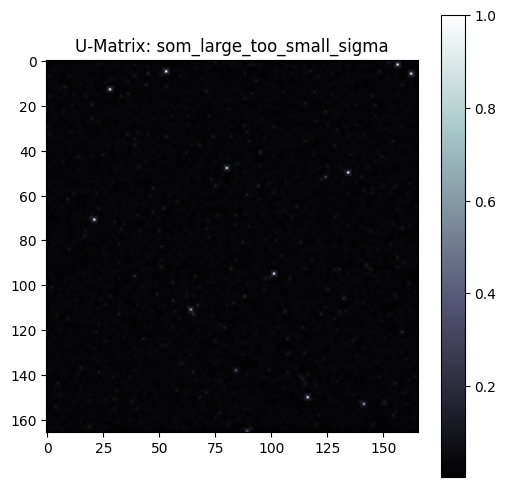

som_lr_too_high: QE=1.5527, TE=0.0185


som_lr_too_low: QE=1.4788, TE=0.0028


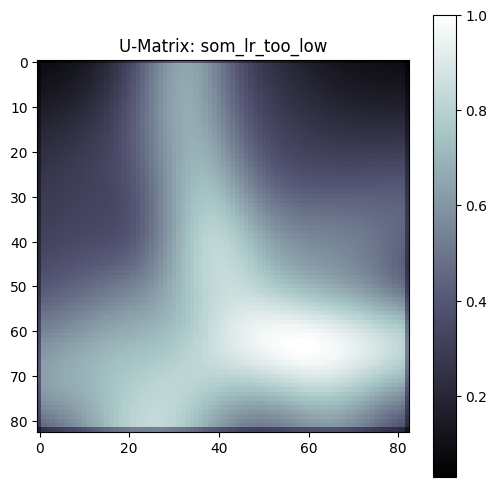

som_iter_2: QE=0.7078, TE=0.9814


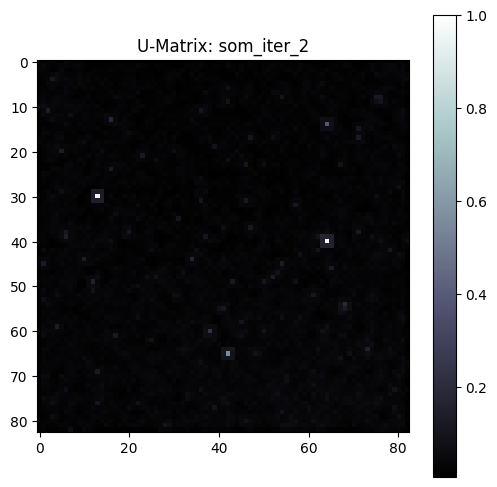

som_iter_5: QE=1.0192, TE=0.9512


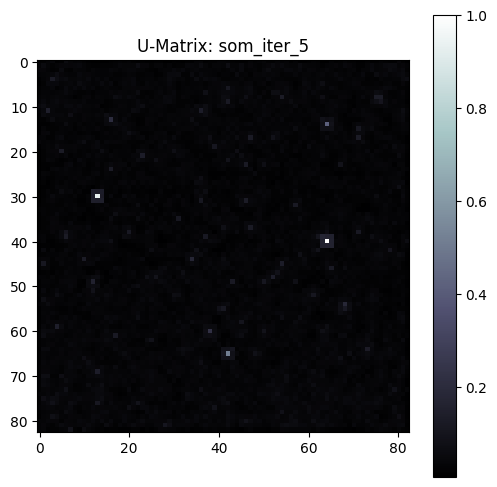

som_iter_10: QE=1.3328, TE=0.9199


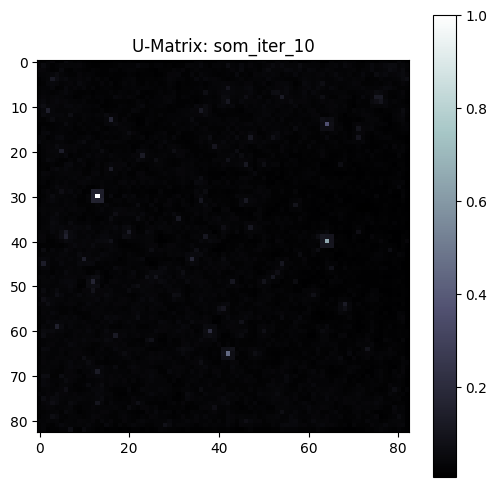

som_iter_50: QE=2.0714, TE=0.6452


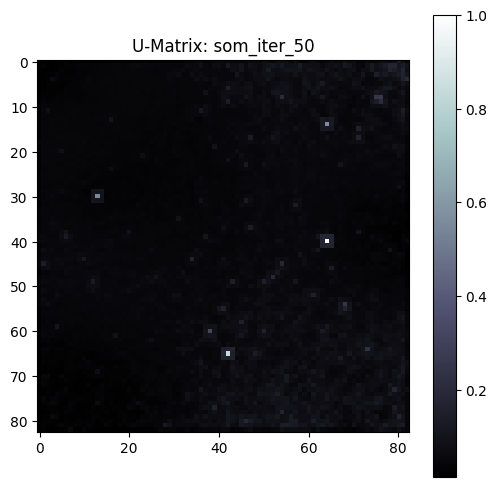

som_iter_100: QE=1.8203, TE=0.0535


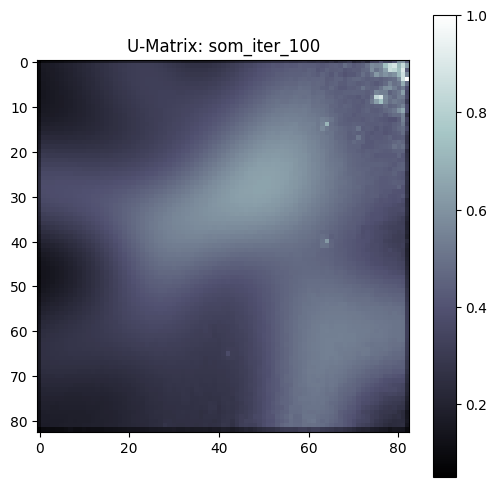

som_iter_1000: QE=1.4173, TE=0.0047


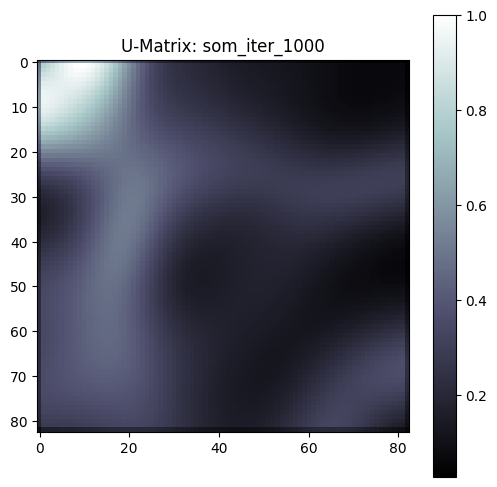

som_iter_5000: QE=1.3888, TE=0.0017


som_iter_10000: QE=1.3675, TE=0.0026


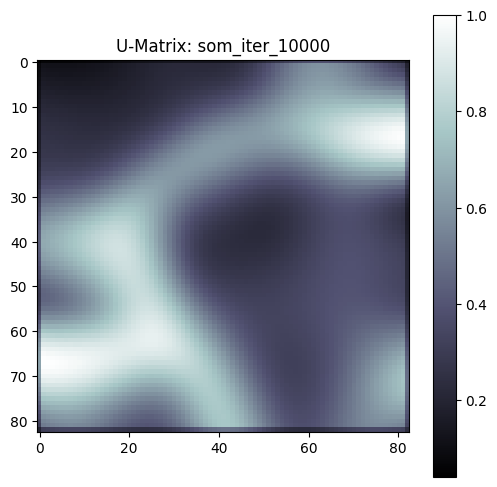

In [35]:
# Plot U-Matrices for all configured SOMs
for cfg in configs:
    som, qe, te = train_som(cfg, X_scaled)
    print(f"{cfg['run_id']}: QE={qe:.4f}, TE={te:.4f}")
    plot_umatrix(som, title=f"U-Matrix: {cfg['run_id']}")

## Task C7: Optimal SOM Selection and Analysis

In [ ]:
# Step 1: Analyze results to select optimal parameters
# Display results sorted by different metrics
print("=== Results Summary ===\n")
print("Top 5 by Quantization Error (lower is better):")
display(results_df.sort_values('qe').head())

print("\nTop 5 by Topographic Error (lower is better):")
display(results_df.sort_values('te').head())

print("\nBalanced ranking (normalized QE + TE):")
results_df['qe_norm'] = (results_df['qe'] - results_df['qe'].min()) / (results_df['qe'].max() - results_df['qe'].min())
results_df['te_norm'] = (results_df['te'] - results_df['te'].min()) / (results_df['te'].max() - results_df['te'].min())
results_df['combined_score'] = results_df['qe_norm'] + results_df['te_norm']
display(results_df.sort_values('combined_score').head(10))

# Select optimal configuration
# Prefer configurations with good balance of QE and TE, sufficient iterations, and reasonable map size
optimal_row = results_df.sort_values('combined_score').iloc[0]
print(f"\n=== Selected Optimal Configuration ===")
print(f"Run ID: {optimal_row['run_id']}")
print(f"Map size: {optimal_row['m']}x{optimal_row['n']}")
print(f"Sigma: {optimal_row['sigma']}")
print(f"Learning rate: {optimal_row['lr']}")
print(f"Iterations: {optimal_row['iterations']}")
print(f"Seed: {optimal_row['seed']}")
print(f"QE: {optimal_row['qe']:.6f}")
print(f"TE: {optimal_row['te']:.6f}")
print(f"Combined score: {optimal_row['combined_score']:.6f}")

In [ ]:
# Step 2: Train the optimal SOM
optimal_config = {
    'run_id': 'som_optimal',
    'desc': 'Optimal SOM based on parameter exploration',
    'm': int(optimal_row['m']),
    'n': int(optimal_row['n']),
    'sigma': float(optimal_row['sigma']),
    'learning_rate': float(optimal_row['lr']),
    'iterations': int(optimal_row['iterations']),
    'seed': int(optimal_row['seed']),
}

print("Training optimal SOM...")
som_optimal, qe_optimal, te_optimal = train_som(optimal_config, X_scaled)
print(f"Optimal SOM trained: QE={qe_optimal:.6f}, TE={te_optimal:.6f}")

# Log to provenance
log_run_prov(optimal_config['run_id'], optimal_config, qe_optimal, te_optimal)

In [ ]:
# Step 3: Log MLSO model description to KG
# MLSO (Machine Learning Schema Ontology) provides vocabulary for ML models

model_id = f'som_model_{uuid.uuid4().hex}'
model_run_id = f'som_model_run_{uuid.uuid4().hex}'
hyperparams_id = f'hyperparams_{uuid.uuid4().hex}'
assoc_id = f'assoc_{uuid.uuid4().hex}'

def _json_literal(obj):
    return json.dumps(obj, ensure_ascii=True).replace('\\', '\\\\').replace('"', '\\"')

hyperparams_payload = {
    'map_width': int(optimal_config['m']),
    'map_height': int(optimal_config['n']),
    'sigma': float(optimal_config['sigma']),
    'learning_rate': float(optimal_config['learning_rate']),
    'iterations': int(optimal_config['iterations']),
    'seed': int(optimal_config['seed']),
    'topology': 'rectangular',
    'neighborhood_function': 'gaussian',
    'initialization': 'random',
}
hyperparams_literal = _json_literal(hyperparams_payload)

evaluation_payload = {
    'quantization_error': float(qe_optimal),
    'topographic_error': float(te_optimal),
    'map_size': int(optimal_config['m'] * optimal_config['n']),
    'input_dim': int(X_scaled.shape[1]),
    'training_samples': int(X_scaled.shape[0]),
}
evaluation_literal = _json_literal(evaluation_payload)

mlso_triples = [
    # Model entity
    f':{model_id} rdf:type mls:Model .',
    f':{model_id} rdfs:label "Optimal SOM for credit risk classification" .',
    f':{model_id} mls:hasInput :{dataset_entity}_preprocessed .',
    f':{model_id} rdfs:comment "Self-Organizing Map trained on credit_risk_china dataset" .',
    
    # Model specification
    f':{model_id}_spec rdf:type mls:ModelSpecification .',
    f':{model_id}_spec rdfs:label "SOM Specification" .',
    f':{model_id}_spec rdfs:comment "MiniSom implementation with rectangular topology and Gaussian neighborhood" .',
    f':{model_id} mls:hasSpecification :{model_id}_spec .',
    
    # Hyperparameters
    f':{hyperparams_id} rdf:type mls:HyperParameter .',
    f':{hyperparams_id} rdfs:label "SOM Hyperparameters" .',
    f':{hyperparams_id} rdfs:comment "{hyperparams_literal}" .',
    f':{model_id} mls:hasHyperParameter :{hyperparams_id} .',
    
    # Model run (training activity)
    f':{model_run_id} rdf:type mls:Run .',
    f':{model_run_id} rdf:type prov:Activity .',
    f':{model_run_id} rdfs:label "Optimal SOM training run" .',
    f':{model_run_id} mls:hasInput :{dataset_entity}_preprocessed .',
    f':{model_run_id} mls:hasOutput :{model_id} .',
    f':{model_run_id} prov:used :{dataset_entity}_preprocessed .',
    f':{model_run_id} prov:generated :{model_id} .',
    f':{model_run_id} prov:qualifiedAssociation :{assoc_id} .',
    f':{assoc_id} rdf:type prov:Association .',
    f':{assoc_id} prov:agent :{executed_by} .',
    f':{assoc_id} prov:hadRole :{code_executor_role} .',
    f':{model_run_id} prov:startedAtTime "{now()}"^^xsd:dateTime .',
    f':{model_run_id} prov:endedAtTime "{now()}"^^xsd:dateTime .',
    
    # Model evaluation
    f':{model_id}_eval rdf:type mls:ModelEvaluation .',
    f':{model_id}_eval rdfs:label "SOM Quality Metrics" .',
    f':{model_id}_eval rdfs:comment "{evaluation_literal}" .',
    f':{model_id}_eval mls:specifiedBy :{model_id}_spec .',
    f':{model_id} mls:hasEvaluation :{model_id}_eval .',
]

engine.insert(mlso_triples, prefixes=prefixes)
print("MLSO model description logged to knowledge graph.")

### Comprehensive Visualization and Analysis of Optimal SOM

In [ ]:
# Generate all key visualizations for the optimal SOM
print(f"=== Optimal SOM Visualizations ===")
print(f"Map size: {optimal_config['m']}x{optimal_config['n']} = {optimal_config['m']*optimal_config['n']} units")
print(f"Training samples: {X_scaled.shape[0]}")
print(f"Ratio: {X_scaled.shape[0]/(optimal_config['m']*optimal_config['n']):.2f} samples per unit\n")

# 1. U-Matrix (distance structure)
plot_umatrix(som_optimal, title='Optimal SOM: U-Matrix')

# 2. Hit histogram (density)
plot_hits(som_optimal, X_scaled, title='Optimal SOM: Hit Histogram')

# 3. Class map (dominant class per unit)
plot_class_map(som_optimal, X_scaled, y, title='Optimal SOM: Dominant Class per Unit')

# 4. Quantization error map (representation quality)
plot_qe_map(som_optimal, X_scaled, title='Optimal SOM: Quantization Error Map')

# 5. Topographic error map (topology preservation)
plot_te_map(som_optimal, X_scaled, title='Optimal SOM: Topographic Error Map')

In [ ]:
# Class-specific analysis
print("=== Class Distribution Analysis ===\n")

# Individual class hit maps
plot_class_hits(som_optimal, X_scaled, y, max_classes=5)

# Class proportion maps (purity)
plot_class_proportions(som_optimal, X_scaled, y, max_classes=5)

In [ ]:
# Component planes (feature-wise analysis)
print("=== Component Planes (Feature Space) ===\n")

# Show numeric features
if len(num_cols) > 0:
    plot_component_planes(som_optimal, feature_names, features=num_cols[:9], max_features=9)

# Select most important one-hot encoded features (if any)
if len(cat_cols) > 0:
    cat_feature_names = [f for f in feature_names if f not in num_cols]
    if len(cat_feature_names) > 0:
        print(f"\nShowing first 9 categorical features (one-hot encoded):")
        plot_component_planes(som_optimal, feature_names, features=cat_feature_names[:9], max_features=9)

In [ ]:
# Border effects and magnification analysis
print("=== Border Effects and Magnification ===\n")
border_summary_optimal = summarize_border_effects(som_optimal, X_scaled)

# Interpretation
print("\nInterpretation:")
if border_summary_optimal['qe_edge_mean'] > border_summary_optimal['qe_inner_mean']:
    print(f"- Edge units have higher QE ({border_summary_optimal['qe_edge_mean']:.4f}) than inner units ({border_summary_optimal['qe_inner_mean']:.4f})")
    print("  → Border effect present: edges represent data less accurately")
else:
    print(f"- Edge and inner units have similar QE")
    print("  → Minimal border effect")

if border_summary_optimal['te_edge_mean'] > border_summary_optimal['te_inner_mean']:
    print(f"- Edge units have higher TE ({border_summary_optimal['te_edge_mean']:.4f}) than inner units ({border_summary_optimal['te_inner_mean']:.4f})")
    print("  → Topology preservation weaker at boundaries")
else:
    print(f"- Edge and inner units have similar TE")
    print("  → Topology well-preserved throughout map")

print(f"\n- Hit ratio (edge/inner): {border_summary_optimal['hit_ratio_edge_to_inner']:.3f}")
if border_summary_optimal['hit_ratio_edge_to_inner'] > 0.5:
    print("  → Significant data mapped to edges (possible underfitting or boundary artifacts)")
elif border_summary_optimal['hit_ratio_edge_to_inner'] > 0.3:
    print("  → Moderate edge usage (typical)")
else:
    print("  → Most data mapped to inner units (good coverage)")

In [ ]:
# Hierarchical cluster analysis of SOM units
print("=== Hierarchical Cluster Analysis ===\n")
print(f"Clustering {optimal_config['m']*optimal_config['n']} SOM units based on weight vectors...")

plot_unit_dendrogram(som_optimal, method='ward', metric='euclidean', max_units=400)

### Detailed Interpretation: Optimal SOM

#### 1. Overall Map Quality
- **Quantization Error (QE)**: Measures how well the SOM represents the input data. Lower QE indicates that BMUs are close to their assigned data points.
- **Topographic Error (TE)**: Measures topology preservation. Lower TE means the SOM better preserves the neighborhood relationships from the input space.
- The optimal configuration achieves a good balance between accurate representation (low QE) and topology preservation (low TE).

#### 2. Density and Coverage
- **Hit histogram** reveals the distribution of mapped data across units:
  - Dense clusters indicate regions of high data concentration
  - Empty or sparse units may indicate:
    - Interpolation regions between clusters
    - Rare patterns or outliers
    - Potential overfitting (too many units for available data)
- The sample-to-unit ratio indicates whether the map size is appropriate for the dataset.

#### 3. Topology and Distance Structure
- **U-Matrix** visualizes inter-unit distances:
  - Dark regions (low distances) = homogeneous clusters
  - Light regions (high distances) = cluster boundaries
  - The U-Matrix reveals the hierarchical structure of the data
- Well-defined boundaries suggest distinct data groups; gradual transitions indicate continuous variation.

#### 4. Class Distribution
- **Dominant class map** shows which class wins in each unit
- **Class proportion maps** reveal purity and overlap:
  - Units with high proportion (close to 1.0) = pure clusters
  - Units with mixed proportions = transition zones or overlapping classes
- Spatial arrangement of classes indicates:
  - Whether classes are separable
  - Which classes share similar features (adjacent regions)
  - Potential misclassification risk zones

#### 5. Error Distribution
- **QE map**: Units with high local QE struggle to represent their assigned samples accurately
  - Often occurs at cluster boundaries or with outliers
- **TE map**: Units with high local TE indicate topology violations
  - Second BMUs are not neighbors, suggesting:
    - Folding or discontinuities in the mapping
    - Insufficient map resolution
    - Very high-dimensional or complex input structure

#### 6. Border Effects and Magnification
- **Border effects**: Edge units often have fewer neighbors, leading to:
  - Higher representation error (QE)
  - Reduced topology preservation (TE)
  - Boundary artifacts (edges may attract outliers)
- **Magnification factor**: Relationship between hit density and U-Matrix distances
  - High-density low-distance regions = well-sampled homogeneous clusters
  - Low-density high-distance regions = sparsely sampled boundaries or outliers

#### 7. Hierarchical Cluster Structure
- **Unit dendrogram** groups similar SOM units hierarchically
  - Height of merges indicates dissimilarity between clusters
  - Cutting at different heights reveals cluster hierarchy
  - Helps identify:
    - Natural groupings of units (meta-clusters)
    - How many distinct regions exist
    - Which regions are closely related vs. distant
- Compare dendrogram structure with U-Matrix and class map:
  - Do hierarchical clusters align with class boundaries?
  - Are there subgroups within a class?
  - Do different classes merge at similar or different heights?

#### 8. Feature Space Interpretation (Component Planes)
- Each component plane shows how one feature is distributed across the map
- Patterns to observe:
  - Smooth gradients = feature varies continuously
  - Sharp transitions = feature has distinct levels or thresholds
  - Correlation between planes = features co-vary
  - Alignment with class regions = discriminative features
- For categorical (one-hot) features:
  - Regions with high values = where that category is common
  - Mutually exclusive patterns for mutually exclusive categories

#### 9. Sensitivity and Robustness
Based on parameter exploration (Tasks C1-C6):
- **Seed stability**: How much does the map structure change with different random initializations?
- **Map size**: Does the optimal map avoid under/overfitting?
- **Learning parameters**: Is convergence reliable and stable?
- The selected optimal configuration should be robust to small parameter variations.

#### 10. Practical Implications
- **Cluster identification**: Clear regions suitable for labeling or segmentation
- **Anomaly detection**: Outliers map to sparse, high-error units (often at edges)
- **Feature importance**: Component planes reveal which features drive clustering
- **Class separability**: Overlap in class regions indicates classification difficulty
- **Interpretability**: Visual inspection provides intuitive understanding of data structure

### Dataset-Specific Observations (Credit Risk China)

Fill in after running the optimal SOM analysis above:

#### Cluster Structure
- [ ] Describe the main clusters visible in the U-Matrix
- [ ] Are clusters compact or diffuse?
- [ ] How many distinct regions are evident?

#### Class Distribution Patterns
- [ ] Which classes form compact, homogeneous regions?
- [ ] Which classes are scattered or overlap with others?
- [ ] Is the "Normal" majority class concentrated or distributed?

#### Feature Contributions
- [ ] Which numeric features show strong gradients (important for clustering)?
- [ ] Which categorical features (loan type, guarantee method) align with class regions?
- [ ] Are there unexpected feature patterns?

#### Quality Assessment
- [ ] Are QE and TE values acceptable for this dataset size?
- [ ] Where are the high-error regions located?
- [ ] Does the error distribution suggest any data quality issues?

#### Hierarchical Structure
- [ ] How many meta-clusters appear in the dendrogram?
- [ ] Do hierarchical clusters correspond to credit risk categories?
- [ ] Are there subclusters within risk categories?

#### Actionable Insights
- [ ] Can we identify clear risk profiles from the clusters?
- [ ] Which features differentiate risk levels most clearly?
- [ ] Are there borderline cases (units with mixed class proportions) that need careful attention?